In [1]:
import numpy as np
import pandas as pd
import h5py
import os
import glob
from datetime import datetime
from datetime import timedelta
from matplotlib import pyplot as plt
import matplotlib.dates as md
import warnings
from scipy.interpolate import interp2d
from scipy.interpolate import interp1d
from scipy.interpolate import make_interp_spline
warnings.filterwarnings('ignore')
import scipy.ndimage as ndimage
from matplotlib import cm
from matplotlib.colors import LogNorm
from sklearn import preprocessing
import seaborn as sns
from scipy.stats import pearsonr
from scipy import stats

In [2]:
def simple_read(path):
    with open(path) as f:
        first_line = f.readline()
        header_line = int(first_line[0:-2].split(",")[0])-1
        #all_lines = f.readlines()
    data = pd.read_csv(path, sep=',', skiprows=header_line)
    data.columns = [i.strip() for i in data.columns]
    #date = all_lines[5][0:10].split(',')
    #dt = datetime(int(date[0]), int(date[1]), int(date[2]))

    acc = 0
    boo = False
    for letter in path:
        if letter == '2':
            boo = True
        elif boo and letter == '0':
            acc -= 1
            break
        acc += 1
    #print(path[:acc+4], path[acc+4:acc+6], path[acc+6:acc+8])
    dt = datetime(int(path[acc:acc+4]), int(path[acc+4:acc+6]), int(path[acc+6:acc+8]))
    
    for column in data.keys():
        if 'Time' in column:
            data[column] = dt + pd.to_timedelta(data[column], unit='seconds')
    return data.replace(-999999, np.NaN)

In [3]:
DAY2 = simple_read('C:/Users/taiwoajayi/Desktop/chem/activate-mrg1_hu25_20220602_R0_L1_20230614T111634.ict')
start_index = np.where(DAY2["Time_Start"]==pd.to_datetime("2022-06-02 13:48:00"))
stop_index = np.where(DAY2["Time_Start"]==pd.to_datetime("2022-06-02 14:10:00"))
    
DAY2_subset = DAY2[start_index[0][0]:stop_index[0][0]]
DAY2_subset = DAY2_subset.replace(-888888, 0)
DAY2_subset


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
8926,2022-06-02 13:48:00,2022-06-02 13:48:01,32.397719,-65.920473,1896.68,0.241,0.453,0.108,0.114,0.008,-0.049
8927,2022-06-02 13:48:01,2022-06-02 13:48:02,32.397400,-65.918900,1897.28,0.241,0.453,0.108,0.114,0.008,-0.049
8928,2022-06-02 13:48:02,2022-06-02 13:48:03,32.397079,-65.917327,1898.01,0.241,0.453,0.108,0.114,0.008,-0.049
8929,2022-06-02 13:48:03,2022-06-02 13:48:04,32.396758,-65.915754,1898.83,0.241,0.453,0.108,0.114,0.008,-0.049
8930,2022-06-02 13:48:04,2022-06-02 13:48:05,32.396435,-65.914182,1899.75,0.241,0.453,0.108,0.114,0.008,-0.049
...,...,...,...,...,...,...,...,...,...,...,...
10241,2022-06-02 14:09:55,2022-06-02 14:09:56,32.272869,-64.969777,2855.32,0.475,0.315,0.002,0.133,0.035,0.004
10242,2022-06-02 14:09:56,2022-06-02 14:09:57,32.273564,-64.970808,2861.28,0.475,0.315,0.002,0.133,0.035,0.004
10243,2022-06-02 14:09:57,2022-06-02 14:09:58,32.274234,-64.971861,2867.15,0.475,0.315,0.002,0.133,0.035,0.004
10244,2022-06-02 14:09:58,2022-06-02 14:09:59,32.274877,-64.972937,2872.99,0.475,0.315,0.002,0.133,0.035,0.004


In [4]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY2_subset.GPS_Altitude_THORNHILL.min(), DAY2_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY2_subset['Bins'] = pd.cut(DAY2_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY2_subset_1000 = DAY2_subset.groupby('Bins').mean()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY2_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY2_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_1000 = DAY2_subset_1000[start_index:stop_index]
DAY1000_subset_1000


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
Bins,,,,,,,,,,,
"(106.28, 134.006]",2022-06-02 13:58:08.316455680,2022-06-02 13:58:09.316455680,32.208589,-65.046984,121.847785,0.372076,1.455430,0.030595,0.533494,0.021291,-0.028734
"(134.006, 161.732]",2022-06-02 13:58:10.600000000,2022-06-02 13:58:11.600000000,32.212691,-65.043093,148.533600,0.406040,1.455520,0.032080,0.620440,0.070400,0.014680
"(161.732, 189.459]",2022-06-02 13:58:12.588235264,2022-06-02 13:58:13.588235264,32.218407,-65.041818,174.502647,0.376588,1.475647,0.026412,0.572882,0.048235,0.023941
"(189.459, 217.185]",2022-06-02 13:58:03.454545664,2022-06-02 13:58:04.454545408,32.224814,-65.054117,203.336364,0.486182,1.480727,0.001545,0.533545,-0.030273,0.042000
"(217.185, 244.911]",2022-06-02 13:57:54.700000000,2022-06-02 13:57:55.700000000,32.229233,-65.065482,231.925500,0.482200,1.481000,0.002800,0.534200,-0.031200,0.044400
"(244.911, 272.637]",2022-06-02 13:58:08.000000000,2022-06-02 13:58:09.000000256,32.231133,-65.053264,259.895833,0.489500,1.480500,0.000500,0.533000,-0.029500,0.040000
"(272.637, 300.363]",2022-06-02 13:58:30.894736896,2022-06-02 13:58:31.894736896,32.235800,-65.035237,283.662895,0.499105,1.479842,-0.002526,0.531421,-0.027263,0.034211
"(300.363, 328.09]",2022-06-02 13:57:43.642857216,2022-06-02 13:57:44.642857216,32.243336,-65.088576,313.085357,0.142071,1.453500,0.013429,0.486357,-0.011500,-0.011357
"(328.09, 355.816]",2022-06-02 13:57:48.700000000,2022-06-02 13:57:49.700000000,32.246542,-65.087461,340.071000,-0.021400,1.437000,0.016200,0.446000,-0.009200,-0.034600


In [5]:

#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3000

start_index = np.where(DAY2_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY2_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY3000_subset_3000 = DAY2_subset_1000[start_index:stop_index]
DAY3000_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
Bins,,,,,,,,,,,
"(993.518, 1021.245]",2022-06-02 13:58:28.875000064,2022-06-02 13:58:29.875000064,32.265496,-65.181578,1005.609375,0.198250,1.096625,0.094125,0.458250,0.012375,-0.056000
"(1021.245, 1048.971]",2022-06-02 13:58:30.875000064,2022-06-02 13:58:31.875000064,32.267893,-65.180104,1036.225000,0.198250,1.096625,0.094125,0.458250,0.012375,-0.056000
"(1048.971, 1076.697]",2022-06-02 14:00:25.300000000,2022-06-02 14:00:26.300000000,32.256697,-65.074768,1061.471000,0.243400,1.136000,0.117400,0.377400,0.017800,-0.064400
"(1076.697, 1104.423]",2022-06-02 13:58:37.124999936,2022-06-02 13:58:38.124999936,32.275372,-65.176683,1089.870000,0.198250,1.096625,0.094125,0.458250,0.012375,-0.056000
"(1104.423, 1132.149]",2022-06-02 13:59:06.666666752,2022-06-02 13:59:07.666666496,32.276005,-65.151618,1119.245556,0.120333,0.980667,0.040333,0.403667,-0.009667,-0.054000
...,...,...,...,...,...,...,...,...,...,...,...
"(2712.543, 2740.269]",2022-06-02 14:09:22.000000000,2022-06-02 14:09:23.000000000,32.239794,-64.957288,2728.482727,0.717000,0.372000,0.058000,0.176000,0.010000,0.020000
"(2740.269, 2767.995]",2022-06-02 14:09:30.500000000,2022-06-02 14:09:31.500000000,32.249103,-64.955685,2752.315000,0.717000,0.372000,0.058000,0.176000,0.010000,0.020000
"(2767.995, 2795.721]",2022-06-02 14:09:38.000000000,2022-06-02 14:09:39.000000000,32.257308,-64.957425,2783.561111,0.663222,0.359333,0.045556,0.166444,0.015556,0.016444


In [6]:
DAY2b = simple_read('C:/Users/taiwoajayi/Desktop/chem/activate-mrg1_hu25_20220602_R0_L2_20230614T111634.ict')
start_index = np.where(DAY2b["Time_Start"]==pd.to_datetime("2022-06-02 18:36:00"))
stop_index = np.where(DAY2b["Time_Start"]==pd.to_datetime("2022-06-02 18:53:00"))
DAY2b_subset = DAY2b[start_index[0][0]:stop_index[0][0]]
DAY2b_subset = DAY2b_subset.replace(-888888, 0)
DAY2b_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
9180,2022-06-02 18:36:00,2022-06-02 18:36:01,32.312301,-65.009805,191.225,0.669,1.479,-0.051,0.057,0.028,-0.033
9181,2022-06-02 18:36:01,2022-06-02 18:36:02,32.312336,-65.010962,193.480,0.669,1.479,-0.051,0.057,0.028,-0.033
9182,2022-06-02 18:36:02,2022-06-02 18:36:03,32.312332,-65.012116,195.600,0.669,1.479,-0.051,0.057,0.028,-0.033
9183,2022-06-02 18:36:03,2022-06-02 18:36:04,32.312294,-65.013268,197.010,0.669,1.479,-0.051,0.057,0.028,-0.033
9184,2022-06-02 18:36:04,2022-06-02 18:36:05,32.312221,-65.014415,197.440,0.669,1.479,-0.051,0.057,0.028,-0.033
...,...,...,...,...,...,...,...,...,...,...,...
10195,2022-06-02 18:52:55,2022-06-02 18:52:56,32.205808,-64.977280,3678.610,0.836,0.176,0.024,-0.174,-0.012,0.066
10196,2022-06-02 18:52:56,2022-06-02 18:52:57,32.205215,-64.976028,3684.900,0.836,0.176,0.024,-0.174,-0.012,0.066
10197,2022-06-02 18:52:57,2022-06-02 18:52:58,32.204648,-64.974760,3691.340,0.836,0.176,0.024,-0.174,-0.012,0.066
10198,2022-06-02 18:52:58,2022-06-02 18:52:59,32.204104,-64.973478,3697.790,0.836,0.176,0.024,-0.174,-0.012,0.066


In [7]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY2b_subset.GPS_Altitude_THORNHILL.min(), DAY2b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY2b_subset['Bins'] = pd.cut(DAY2b_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY2b_subset_1000 = DAY2b_subset.groupby('Bins').mean()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY2b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY2b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_1000b = DAY2b_subset_1000[start_index:stop_index]
DAY1000_subset_1000b

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
Bins,,,,,,,,,,,
"(132.5, 168.217]",2022-06-02 18:36:33.700000000,2022-06-02 18:36:34.700,32.294115,-65.038343,150.110167,0.564833,1.527333,0.084000,0.057000,0.051333,0.002000
"(168.217, 203.933]",2022-06-02 18:36:19.440000000,2022-06-02 18:36:20.440,32.302282,-65.024822,185.682600,0.618200,1.485960,-0.014680,0.082200,0.033840,-0.018200
"(203.933, 239.65]",2022-06-02 18:37:02.000000000,2022-06-02 18:37:03.000,32.265794,-65.038727,217.346923,0.284000,1.450000,0.079000,0.372000,0.045000,0.068000
"(239.65, 275.366]",2022-06-02 18:37:13.000000000,2022-06-02 18:37:14.000,32.254753,-65.034836,258.630000,0.284000,1.450000,0.079000,0.372000,0.045000,0.068000
"(275.366, 311.083]",2022-06-02 18:37:23.999999744,2022-06-02 18:37:25.000,32.245202,-65.026887,290.658077,0.178769,1.348462,0.050846,0.413077,0.033462,0.051846
"(311.083, 346.8]",2022-06-02 18:37:38.000000000,2022-06-02 18:37:39.000,32.237366,-65.011798,330.868333,0.056000,1.230000,0.018000,0.461000,0.020000,0.033000
"(346.8, 382.516]",2022-06-02 18:37:53.000000000,2022-06-02 18:37:54.000,32.237006,-64.992797,363.542667,0.136400,1.150000,0.014800,0.444600,0.002400,0.021000
"(382.516, 418.233]",2022-06-02 18:38:07.000000000,2022-06-02 18:38:08.000,32.244580,-64.977394,399.478462,0.257000,1.030000,0.010000,0.420000,-0.024000,0.003000
"(418.233, 453.949]",2022-06-02 18:38:19.000000000,2022-06-02 18:38:20.000,32.255481,-64.969336,433.617273,0.257000,1.030000,0.010000,0.420000,-0.024000,0.003000


In [8]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY2b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY2b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY3000_subset_3000b = DAY2b_subset_1000[start_index:stop_index]
DAY3000_subset_3000b

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
Bins,,,,,,,,,,,
"(989.698, 1025.415]",2022-06-02 18:41:23.000,2022-06-02 18:41:24.000,32.269884,-64.947261,1010.109286,0.352571,0.867714,-0.001286,0.225857,0.005714,-0.003000
"(1025.415, 1061.132]",2022-06-02 18:41:31.500,2022-06-02 18:41:32.500,32.278879,-64.945764,1045.848000,0.099000,0.852000,0.028000,0.478000,-0.015000,-0.043000
"(1061.132, 1096.848]",2022-06-02 18:41:40.500,2022-06-02 18:41:41.500,32.288298,-64.947187,1080.382500,0.099000,0.852000,0.028000,0.478000,-0.015000,-0.043000
"(1096.848, 1132.565]",2022-06-02 18:41:52.500,2022-06-02 18:41:53.500,32.298942,-64.954631,1113.911250,0.120875,0.761875,0.031938,0.313937,-0.011062,-0.008875
"(1132.565, 1168.281]",2022-06-02 18:42:04.500,2022-06-02 18:42:05.500,32.306134,-64.966376,1149.516250,0.149000,0.646000,0.037000,0.103000,-0.006000,0.035000
...,...,...,...,...,...,...,...,...,...,...,...
"(3275.561, 3311.277]",2022-06-02 18:51:48.500,2022-06-02 18:51:49.500,32.275042,-65.008035,3293.825000,0.146000,0.180000,-0.048000,0.147000,0.026000,-0.033000
"(3311.277, 3346.994]",2022-06-02 18:51:54.000,2022-06-02 18:51:55.000,32.268640,-65.008707,3329.810000,0.181600,0.183600,-0.026000,0.119800,0.032400,-0.028200
"(3346.994, 3382.711]",2022-06-02 18:51:59.000,2022-06-02 18:52:00.000,32.262832,-65.009195,3366.570000,0.235000,0.189000,0.007000,0.079000,0.042000,-0.021000


In [9]:
DAY3 = simple_read('C:/Users/taiwoajayi/Desktop/chem/activate-mrg1_hu25_20220603_R0_20230614T111635.ict')
start_index= np.where(DAY3["Time_Start"]==pd.to_datetime("2022-06-03 13:30:00"))
stop_index= np.where(DAY3["Time_Start"]==pd.to_datetime("2022-06-03 15:00:00"))
    
DAY3_subset = DAY3[start_index[0][0]:stop_index[0][0]]
DAY3_subset = DAY3_subset.replace(-888888, 0)
DAY3_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
2467,2022-06-03 13:30:00,2022-06-03 13:30:01,33.872982,-67.052387,2858.90,0.343,0.244,-0.017,0.025,-0.002,0.050
2468,2022-06-03 13:30:01,2022-06-03 13:30:02,33.872534,-67.053832,2861.55,0.343,0.244,-0.017,0.025,-0.002,0.050
2469,2022-06-03 13:30:02,2022-06-03 13:30:03,33.872086,-67.055272,2863.82,0.343,0.244,-0.017,0.025,-0.002,0.050
2470,2022-06-03 13:30:03,2022-06-03 13:30:04,33.871638,-67.056704,2865.57,0.343,0.244,-0.017,0.025,-0.002,0.050
2471,2022-06-03 13:30:04,2022-06-03 13:30:05,33.871187,-67.058127,2866.59,0.343,0.244,-0.017,0.025,-0.002,0.050
...,...,...,...,...,...,...,...,...,...,...,...
7862,2022-06-03 14:59:55,2022-06-03 14:59:56,32.712767,-65.244314,2413.61,0.003,0.199,0.020,0.215,0.022,-0.014
7863,2022-06-03 14:59:56,2022-06-03 14:59:57,32.712103,-65.243151,2408.15,0.003,0.199,0.020,0.215,0.022,-0.014
7864,2022-06-03 14:59:57,2022-06-03 14:59:58,32.711441,-65.241989,2402.02,0.003,0.199,0.020,0.215,0.022,-0.014
7865,2022-06-03 14:59:58,2022-06-03 14:59:59,32.710779,-65.240827,2395.43,0.003,0.199,0.020,0.215,0.022,-0.014


In [10]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY3_subset.GPS_Altitude_THORNHILL.min(), DAY3_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY3_subset['Bins'] = pd.cut(DAY3_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY3_subset_1000 = DAY3_subset.groupby('Bins').mean()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY3_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY3_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_3 = DAY3_subset_1000[start_index:stop_index]
DAY1000_subset_3


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
Bins,,,,,,,,,,,
"(94.825, 149.89]",2022-06-03 13:45:28.789007104,2022-06-03 13:45:29.789007104,34.126959,-67.213208,123.892358,0.528630,1.414446,0.015012,0.352340,0.000646,0.035413
"(149.89, 204.956]",2022-06-03 13:48:10.320000000,2022-06-03 13:48:11.319999744,33.927509,-67.395937,181.520500,0.647220,1.318320,0.077060,0.337880,0.015740,0.077720
"(204.956, 260.021]",2022-06-03 13:59:27.145491712,2022-06-03 13:59:28.145491712,34.102741,-67.396328,246.379939,0.432961,1.481289,0.034645,0.391805,0.008484,0.015936
"(260.021, 315.086]",2022-06-03 13:53:11.011236096,2022-06-03 13:53:12.011235840,33.997827,-67.380569,280.595730,0.392404,1.404213,0.030011,0.317101,-0.000146,0.020461
"(315.086, 370.151]",2022-06-03 13:54:31.023809536,2022-06-03 13:54:32.023809536,34.037034,-67.328911,340.301310,0.345738,1.423929,0.017119,0.349429,0.004714,0.034857
"(370.151, 425.217]",2022-06-03 13:54:07.136363520,2022-06-03 13:54:08.136363776,34.095859,-67.060673,402.749318,0.268455,1.452909,0.014818,0.410182,-0.006636,0.028091
"(425.217, 480.282]",2022-06-03 14:03:16.657894656,2022-06-03 14:03:17.657894656,34.148126,-67.167576,453.531184,0.013037,1.494222,0.015185,0.246444,-0.008889,-0.065333
"(480.282, 535.347]",2022-06-03 14:09:48.304114432,2022-06-03 14:09:49.304114688,34.166931,-67.301055,500.509848,0.403031,1.663827,0.025357,0.411857,0.019939,0.029541
"(535.347, 590.412]",2022-06-03 13:56:08.066666752,2022-06-03 13:56:09.066666752,33.903960,-67.359933,562.995667,0.052222,0.969667,0.030333,0.261222,0.020222,0.025889


In [11]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY3_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY3_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY3_subset_3000 = DAY3_subset_1000[start_index:stop_index]
DAY3_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
Bins,,,,,,,,,,,
"(975.869, 1030.934]",2022-06-03 14:08:35.406249984,2022-06-03 14:08:36.406249984,34.003272,-67.474357,1004.015000,0.289219,0.792594,0.002969,0.177813,-0.007156,0.007438
"(1030.934, 1086.0]",2022-06-03 14:10:41.310344960,2022-06-03 14:10:42.310344960,34.016593,-67.498275,1060.067931,0.294897,0.766759,-0.009690,0.209552,-0.010310,-0.004862
"(1086.0, 1141.065]",2022-06-03 14:08:44.529411840,2022-06-03 14:08:45.529411840,33.996922,-67.516110,1107.793824,0.286088,0.744471,-0.009176,0.239206,0.001294,-0.012353
"(1141.065, 1196.13]",2022-06-03 13:54:16.100000000,2022-06-03 13:54:17.100000000,34.028908,-67.067302,1171.628000,0.255000,0.538400,-0.005000,0.215200,-0.005200,-0.065800
"(1196.13, 1251.195]",2022-06-03 14:10:12.407407360,2022-06-03 14:10:13.407407616,34.158616,-67.043866,1215.513704,0.303593,0.509852,-0.027778,0.138667,-0.012185,-0.083111
"(1251.195, 1306.26]",2022-06-03 13:53:27.769230848,2022-06-03 13:53:28.769230592,34.025997,-67.042836,1278.284615,0.308308,0.536385,-0.026923,0.223692,-0.007154,-0.049923
"(1306.26, 1361.326]",2022-06-03 13:59:32.500000000,2022-06-03 13:59:33.500000000,34.077405,-67.028103,1336.740625,0.269500,0.539500,-0.063000,0.464500,-0.005000,-0.026500
"(1361.326, 1416.391]",2022-06-03 14:08:28.166666496,2022-06-03 14:08:29.166666752,34.157498,-67.012562,1384.985417,0.247333,0.530333,-0.072333,0.510000,-0.006000,-0.034000
"(1416.391, 1471.456]",2022-06-03 13:57:09.909090816,2022-06-03 13:57:10.909090816,34.066318,-67.016919,1443.273636,0.275545,0.542000,-0.060455,0.452091,-0.004727,-0.024455


In [12]:
DAY7 = simple_read('C:/Users/taiwoajayi/Desktop/chem/activate-mrg1_hu25_20220607_R0_L1_20230614T111635.ict')
start_index = np.where(DAY7["Time_Start"]==pd.to_datetime("2022-06-07 14:32:00"))
stop_index = np.where(DAY7["Time_Start"]==pd.to_datetime("2022-06-07 14:47:00"))
    
DAY7_subset =DAY7[start_index[0][0]:stop_index[0][0]]
DAY7_subset = DAY7_subset.replace(-888888, 0)
DAY7_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
10397,2022-06-07 14:32:00,2022-06-07 14:32:01,32.250498,-64.999220,127.595,1.99,0.94,0.086,0.069,0.008,0.245
10398,2022-06-07 14:32:01,2022-06-07 14:32:02,32.249883,-64.998233,126.585,1.99,0.94,0.086,0.069,0.008,0.245
10399,2022-06-07 14:32:02,2022-06-07 14:32:03,32.249267,-64.997244,125.870,1.99,0.94,0.086,0.069,0.008,0.245
10400,2022-06-07 14:32:03,2022-06-07 14:32:04,32.248648,-64.996254,125.955,1.99,0.94,0.086,0.069,0.008,0.245
10401,2022-06-07 14:32:04,2022-06-07 14:32:05,32.248027,-64.995263,126.990,1.99,0.94,0.086,0.069,0.008,0.245
...,...,...,...,...,...,...,...,...,...,...,...
11292,2022-06-07 14:46:55,2022-06-07 14:46:56,32.255021,-64.999573,2800.660,0.46,0.33,0.027,-0.270,-0.026,0.072
11293,2022-06-07 14:46:56,2022-06-07 14:46:57,32.255098,-64.998248,2805.770,0.46,0.33,0.027,-0.270,-0.026,0.072
11294,2022-06-07 14:46:57,2022-06-07 14:46:58,32.255152,-64.996919,2810.920,0.46,0.33,0.027,-0.270,-0.026,0.072
11295,2022-06-07 14:46:58,2022-06-07 14:46:59,32.255184,-64.995588,2816.140,0.46,0.33,0.027,-0.270,-0.026,0.072


In [13]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY7_subset.GPS_Altitude_THORNHILL.min(), DAY7_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY7_subset['Bins'] = pd.cut(DAY7_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY7_subset_1000 = DAY7_subset.groupby('Bins').mean()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY7_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY7_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_7 = DAY7_subset_1000[start_index:stop_index]
DAY1000_subset_7


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
Bins,,,,,,,,,,,
"(125.87, 152.826]",2022-06-07 14:32:05.300000000,2022-06-07 14:32:06.300,32.247173,-64.994004,134.321500,2.098600,0.978400,0.086300,0.149700,0.011300,0.283100
"(152.826, 179.781]",2022-06-07 14:32:13.999999744,2022-06-07 14:32:15.000,32.241209,-64.985889,170.347143,2.352000,1.068000,0.087000,0.338000,0.019000,0.372000
"(179.781, 206.737]",2022-06-07 14:32:27.500000000,2022-06-07 14:32:28.500,32.229147,-64.976789,189.676250,2.352000,1.068000,0.087000,0.338000,0.019000,0.372000
"(206.737, 233.692]",2022-06-07 14:32:40.000000000,2022-06-07 14:32:41.000,32.216014,-64.972505,219.682000,2.313000,0.986000,0.089000,0.834000,0.046000,0.296000
"(233.692, 260.648]",2022-06-07 14:32:48.000000000,2022-06-07 14:32:49.000,32.207258,-64.973206,249.774091,2.313000,0.986000,0.089000,0.834000,0.046000,0.296000
"(260.648, 287.604]",2022-06-07 14:33:01.000000000,2022-06-07 14:33:02.000,32.194130,-64.979359,265.369667,2.304800,0.990533,0.087200,0.822400,0.044067,0.295200
"(287.604, 314.559]",2022-06-07 14:33:13.500000000,2022-06-07 14:33:14.500,32.184571,-64.990567,303.789500,2.190000,1.054000,0.062000,0.660000,0.017000,0.284000
"(314.559, 341.515]",2022-06-07 14:33:26.000000000,2022-06-07 14:33:27.000,32.179710,-65.005119,326.685667,2.190000,1.054000,0.062000,0.660000,0.017000,0.284000
"(341.515, 368.47]",2022-06-07 14:33:38.000000000,2022-06-07 14:33:39.000,32.179533,-65.019885,353.990000,2.266667,1.063444,0.060889,0.640000,0.027556,0.285111


In [14]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY7_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY7_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY7_subset_3000 = DAY7_subset_1000[start_index:stop_index]
DAY7_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
Bins,,,,,,,,,,,
"(1015.405, 1042.36]",2022-06-07 14:38:12.000,2022-06-07 14:38:13.000,32.229338,-65.062171,1029.744286,1.328000,1.215000,0.071000,0.464000,-0.0040,0.1430
"(1042.36, 1069.316]",2022-06-07 14:38:21.000,2022-06-07 14:38:22.000,32.236954,-65.057676,1056.277273,1.328000,1.215000,0.071000,0.464000,-0.0040,0.1430
"(1069.316, 1096.272]",2022-06-07 14:38:32.000,2022-06-07 14:38:33.000,32.245122,-65.049970,1083.785455,1.309364,1.227818,0.069091,0.478636,0.0000,0.1420
"(1096.272, 1123.227]",2022-06-07 14:38:42.500,2022-06-07 14:38:43.500,32.251109,-65.040405,1108.407000,1.123000,1.356000,0.050000,0.625000,0.0400,0.1320
"(1123.227, 1150.183]",2022-06-07 14:38:52.000,2022-06-07 14:38:53.000,32.254066,-65.030048,1136.586667,1.123000,1.356000,0.050000,0.625000,0.0400,0.1320
...,...,...,...,...,...,...,...,...,...,...,...
"(2659.696, 2686.652]",2022-06-07 14:46:31.000,2022-06-07 14:46:32.000,32.246791,-65.029386,2672.710000,0.654000,0.201000,-0.077000,0.004000,-0.0470,0.0790
"(2686.652, 2713.608]",2022-06-07 14:46:36.000,2022-06-07 14:46:37.000,32.249473,-65.023645,2699.616000,0.537600,0.278400,-0.014600,-0.160400,-0.0344,0.0748
"(2713.608, 2740.563]",2022-06-07 14:46:41.000,2022-06-07 14:46:42.000,32.251655,-65.017598,2726.148000,0.460000,0.330000,0.027000,-0.270000,-0.0260,0.0720


In [15]:
DAY7b = simple_read('C:/Users/taiwoajayi/Desktop/chem/activate-mrg1_hu25_20220607_R0_L2_20230614T111635.ict')
start_index = np.where(DAY7b["Time_Start"]==pd.to_datetime("2022-06-07 19:08:00"))
stop_index = np.where(DAY7b["Time_Start"]==pd.to_datetime("2022-06-07 19:23:00"))
    
DAY7b_subset = DAY7b[start_index[0][0]:stop_index[0][0]]
DAY7b_subset = DAY7b_subset.replace(-888888, 0)
DAY7b_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
10420,2022-06-07 19:08:00,2022-06-07 19:08:01,32.242823,-65.003952,133.320,0.875,0.562,0.050,0.120,0.004,0.077
10421,2022-06-07 19:08:01,2022-06-07 19:08:02,32.243085,-65.002775,133.120,0.875,0.562,0.050,0.120,0.004,0.077
10422,2022-06-07 19:08:02,2022-06-07 19:08:03,32.243347,-65.001596,132.930,0.875,0.562,0.050,0.120,0.004,0.077
10423,2022-06-07 19:08:03,2022-06-07 19:08:04,32.243610,-65.000416,132.720,0.875,0.562,0.050,0.120,0.004,0.077
10424,2022-06-07 19:08:04,2022-06-07 19:08:05,32.243873,-64.999235,132.595,0.875,0.562,0.050,0.120,0.004,0.077
...,...,...,...,...,...,...,...,...,...,...,...
11315,2022-06-07 19:22:55,2022-06-07 19:22:56,32.296480,-65.011792,3518.030,0.538,0.199,0.045,0.271,0.004,0.148
11316,2022-06-07 19:22:56,2022-06-07 19:22:57,32.296519,-65.013093,3524.890,0.538,0.199,0.045,0.271,0.004,0.148
11317,2022-06-07 19:22:57,2022-06-07 19:22:58,32.296518,-65.014396,3531.840,0.538,0.199,0.045,0.271,0.004,0.148
11318,2022-06-07 19:22:58,2022-06-07 19:22:59,32.296479,-65.015699,3538.850,0.538,0.199,0.045,0.271,0.004,0.148


In [16]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY7b_subset.GPS_Altitude_THORNHILL.min(), DAY7b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY7b_subset['Bins'] = pd.cut(DAY7b_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY7b_subset_1000 = DAY7b_subset.groupby('Bins').mean()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY7b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY7b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_7b = DAY7b_subset_1000[start_index:stop_index]
DAY1000_subset_7b

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
Bins,,,,,,,,,,,
"(132.595, 166.728]",2022-06-07 19:08:08.764705792,2022-06-07 19:08:09.764706048,32.245613,-64.993812,142.995294,0.887588,0.563059,0.060118,0.112706,0.002353,0.077000
"(166.728, 200.861]",2022-06-07 19:08:21.500000000,2022-06-07 19:08:22.500000000,32.252466,-64.980849,183.907500,0.982000,0.571000,0.136000,0.058000,-0.010000,0.077000
"(200.861, 234.994]",2022-06-07 19:08:31.500000000,2022-06-07 19:08:32.500000000,32.261230,-64.974575,218.264583,0.982000,0.571000,0.136000,0.058000,-0.010000,0.077000
"(234.994, 269.127]",2022-06-07 19:08:42.500000000,2022-06-07 19:08:43.500000000,32.272442,-64.972311,251.997000,0.934200,0.546600,0.112200,0.094800,0.000800,0.074800
"(269.127, 303.26]",2022-06-07 19:08:51.500000000,2022-06-07 19:08:52.500000000,32.281693,-64.974483,287.190000,0.743000,0.449000,0.017000,0.242000,0.044000,0.066000
"(303.26, 337.393]",2022-06-07 19:09:01.500000000,2022-06-07 19:09:02.500000000,32.290806,-64.980798,319.254583,0.743000,0.449000,0.017000,0.242000,0.044000,0.066000
"(337.393, 371.526]",2022-06-07 19:09:12.000000000,2022-06-07 19:09:13.000000000,32.298242,-64.990766,354.736667,0.743000,0.449000,0.017000,0.242000,0.044000,0.066000
"(371.526, 405.659]",2022-06-07 19:09:23.500000000,2022-06-07 19:09:24.500000000,32.302454,-65.004622,389.557143,1.129000,0.506000,0.013000,0.278000,-0.008000,0.141000
"(405.659, 439.792]",2022-06-07 19:09:35.000000000,2022-06-07 19:09:36.000000000,32.302506,-65.019551,421.782778,1.129000,0.506000,0.013000,0.278000,-0.008000,0.141000


In [17]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY7b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY7b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY7b_subset_3000 = DAY7b_subset_1000[start_index:stop_index]
DAY7b_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
Bins,,,,,,,,,,,
"(985.921, 1020.054]",2022-06-07 19:12:28.500,2022-06-07 19:12:29.500,32.296148,-64.998385,1003.411000,1.590000,1.208000,0.048000,-0.018000,-0.008000,0.184000
"(1020.054, 1054.187]",2022-06-07 19:12:38.500,2022-06-07 19:12:39.500,32.299974,-65.010363,1037.215000,1.590000,1.208000,0.048000,-0.018000,-0.008000,0.184000
"(1054.187, 1088.32]",2022-06-07 19:12:48.000,2022-06-07 19:12:49.000,32.300554,-65.022498,1071.926667,1.563556,1.275667,0.076778,0.353778,0.009111,0.226778
"(1088.32, 1122.453]",2022-06-07 19:12:58.500,2022-06-07 19:12:59.500,32.297572,-65.035423,1104.758333,1.556000,1.295000,0.085000,0.460000,0.014000,0.239000
"(1122.453, 1156.586]",2022-06-07 19:13:10.500,2022-06-07 19:13:11.500,32.290153,-65.047951,1140.011667,1.548500,1.245583,0.078750,0.463500,0.015417,0.235250
...,...,...,...,...,...,...,...,...,...,...,...
"(3306.969, 3341.102]",2022-06-07 19:22:24.000,2022-06-07 19:22:25.000,32.278726,-64.979771,3325.450000,0.226000,0.098000,-0.037000,0.333000,-0.001000,0.000000
"(3341.102, 3375.235]",2022-06-07 19:22:29.500,2022-06-07 19:22:30.500,32.283554,-64.983849,3359.553333,0.226000,0.098000,-0.037000,0.333000,-0.001000,0.000000
"(3375.235, 3409.368]",2022-06-07 19:22:35.000,2022-06-07 19:22:36.000,32.287882,-64.988668,3393.912000,0.226000,0.098000,-0.037000,0.333000,-0.001000,0.000000


In [18]:
DAY8 = simple_read('C:/Users/taiwoajayi/Desktop/chem/activate-mrg1_hu25_20220608_R0_L2_20230614T111636.ict')
start_index = np.where(DAY8["Time_Start"]==pd.to_datetime("2022-06-08 20:30:00"))
stop_index = np.where(DAY8["Time_Start"]==pd.to_datetime("2022-06-08 20:45:00"))
    
DAY8_subset = DAY8[start_index[0][0]:stop_index[0][0]]
DAY8_subset = DAY8_subset.replace(-888888, 0)
DAY8_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
10668,2022-06-08 20:30:00,2022-06-08 20:30:01,32.267080,-64.998961,152.725,1.050,1.150,0.088,0.330,0.037,0.169
10669,2022-06-08 20:30:01,2022-06-08 20:30:02,32.268158,-64.999178,153.350,1.050,1.150,0.088,0.330,0.037,0.169
10670,2022-06-08 20:30:02,2022-06-08 20:30:03,32.269234,-64.999434,153.870,1.050,1.150,0.088,0.330,0.037,0.169
10671,2022-06-08 20:30:03,2022-06-08 20:30:04,32.270310,-64.999724,154.255,1.050,1.150,0.088,0.330,0.037,0.169
10672,2022-06-08 20:30:04,2022-06-08 20:30:05,32.271382,-65.000051,154.510,1.050,1.150,0.088,0.330,0.037,0.169
...,...,...,...,...,...,...,...,...,...,...,...
11563,2022-06-08 20:44:55,2022-06-08 20:44:56,32.251172,-65.086081,3838.620,0.153,0.308,0.063,0.185,-0.003,0.050
11564,2022-06-08 20:44:56,2022-06-08 20:44:57,32.250122,-65.085465,3847.170,0.153,0.308,0.063,0.185,-0.003,0.050
11565,2022-06-08 20:44:57,2022-06-08 20:44:58,32.249088,-65.084808,3855.660,0.153,0.308,0.063,0.185,-0.003,0.050
11566,2022-06-08 20:44:58,2022-06-08 20:44:59,32.248074,-65.084107,3864.100,0.153,0.308,0.063,0.185,-0.003,0.050


In [19]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY8_subset.GPS_Altitude_THORNHILL.min(), DAY8_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY8_subset['Bins'] = pd.cut(DAY8_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY8_subset_1000 = DAY8_subset.groupby('Bins').mean()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY8_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY8_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_8 = DAY8_subset_1000[start_index:stop_index]
DAY1000_subset_8


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
Bins,,,,,,,,,,,
"(147.455, 184.705]",2022-06-08 20:30:28.263158016,2022-06-08 20:30:29.263158016,32.290577,-65.021135,156.621053,1.078930,1.194088,0.057982,0.241053,0.020386,0.151737
"(184.705, 221.955]",2022-06-08 20:31:07.000000000,2022-06-08 20:31:08.000000000,32.299647,-65.066050,200.296842,0.894000,1.282000,0.001000,0.003000,-0.008000,0.102000
"(221.955, 259.205]",2022-06-08 20:31:21.500000000,2022-06-08 20:31:22.500000000,32.291629,-65.080346,241.513000,0.895600,1.293200,0.008200,-0.034200,-0.006600,0.096800
"(259.205, 296.455]",2022-06-08 20:31:32.500000000,2022-06-08 20:31:33.500000000,32.282682,-65.087075,277.773750,0.902000,1.338000,0.037000,-0.183000,-0.001000,0.076000
"(296.455, 333.705]",2022-06-08 20:31:44.000000000,2022-06-08 20:31:45.000000000,32.272093,-65.089810,314.530000,0.902000,1.338000,0.037000,-0.183000,-0.001000,0.076000
"(333.705, 370.955]",2022-06-08 20:31:54.500000000,2022-06-08 20:31:55.500000000,32.262361,-65.088187,352.470000,0.856000,1.351600,0.034200,-0.117400,-0.012600,0.095200
"(370.955, 408.205]",2022-06-08 20:32:04.500000000,2022-06-08 20:32:05.500000000,32.253986,-65.083164,388.985500,0.787000,1.372000,0.030000,-0.019000,-0.030000,0.124000
"(408.205, 445.455]",2022-06-08 20:32:15.500000000,2022-06-08 20:32:16.500000000,32.246732,-65.074310,425.771250,0.787000,1.372000,0.030000,-0.019000,-0.030000,0.124000
"(445.455, 482.705]",2022-06-08 20:32:27.000000000,2022-06-08 20:32:28.000000000,32.242060,-65.062413,462.363182,0.583364,1.394273,0.048455,0.135000,-0.009636,0.105545


In [20]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY8_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY8_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY8_subset_3000 = DAY8_subset_1000[start_index:stop_index]
DAY8_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
Bins,,,,,,,,,,,
"(1004.206, 1041.456]",2022-06-08 20:35:22.000,2022-06-08 20:35:23.000,32.281197,-65.081842,1020.976364,NaN,NaN,NaN,NaN,NaN,NaN
"(1041.456, 1078.706]",2022-06-08 20:35:35.000,2022-06-08 20:35:36.000,32.268830,-65.078436,1060.526000,1.28800,1.56700,0.0310,0.34300,0.06400,0.16100
"(1078.706, 1115.956]",2022-06-08 20:35:48.500,2022-06-08 20:35:49.500,32.257277,-65.070897,1096.747500,1.28800,1.56700,0.0310,0.34300,0.06400,0.16100
"(1115.956, 1153.206]",2022-06-08 20:36:00.500,2022-06-08 20:36:01.500,32.250081,-65.060047,1134.750833,1.17775,1.50175,0.0280,0.28675,0.01225,0.13025
"(1153.206, 1190.456]",2022-06-08 20:36:12.500,2022-06-08 20:36:13.500,32.247857,-65.046366,1172.759167,1.14100,1.48000,0.0270,0.26800,-0.00500,0.12000
...,...,...,...,...,...,...,...,...,...,...,...
"(3276.459, 3313.709]",2022-06-08 20:43:51.000,2022-06-08 20:43:52.000,32.296061,-65.043973,3293.812000,0.11100,0.25300,-0.0290,0.04100,0.01300,0.02800
"(3313.709, 3350.959]",2022-06-08 20:43:55.500,2022-06-08 20:43:56.500,32.297056,-65.049661,3332.055000,0.11100,0.25300,-0.0290,0.04100,0.01300,0.02800
"(3350.959, 3388.209]",2022-06-08 20:44:00.000,2022-06-08 20:44:01.000,32.297200,-65.055477,3370.516000,0.18420,0.23800,-0.0446,0.02720,0.01660,0.01360


In [21]:
DAY10 = simple_read('C:/Users/taiwoajayi/Desktop/chem/activate-mrg1_hu25_20220610_R0_L1_20230614T111636.ict')
start_index = np.where(DAY10["Time_Start"]==pd.to_datetime("2022-06-10 15:17:00"))
stop_index = np.where(DAY10["Time_Start"]==pd.to_datetime("2022-06-10 15:25:00"))
    
DAY10_subset = DAY10[start_index[0][0]:stop_index[0][0]]
DAY10_subset = DAY10_subset.replace(-888888, 0)
DAY10_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
10616,2022-06-10 15:17:00,2022-06-10 15:17:01,32.206691,-64.996969,122.040,0.311,0.857,0.124,-0.052,-0.006,-0.023
10617,2022-06-10 15:17:01,2022-06-10 15:17:02,32.207809,-64.997169,122.105,0.311,0.857,0.124,-0.052,-0.006,-0.023
10618,2022-06-10 15:17:02,2022-06-10 15:17:03,32.208928,-64.997370,122.170,0.311,0.857,0.124,-0.052,-0.006,-0.023
10619,2022-06-10 15:17:03,2022-06-10 15:17:04,32.210048,-64.997569,122.240,0.311,0.857,0.124,-0.052,-0.006,-0.023
10620,2022-06-10 15:17:04,2022-06-10 15:17:05,32.211167,-64.997768,122.315,0.311,0.857,0.124,-0.052,-0.006,-0.023
...,...,...,...,...,...,...,...,...,...,...,...
11091,2022-06-10 15:24:55,2022-06-10 15:24:56,32.207088,-65.031191,3540.260,0.243,0.189,0.017,-0.335,-0.018,0.027
11092,2022-06-10 15:24:56,2022-06-10 15:24:57,32.207061,-65.029663,3546.970,0.243,0.189,0.017,-0.335,-0.018,0.027
11093,2022-06-10 15:24:57,2022-06-10 15:24:58,32.207068,-65.028134,3553.620,0.243,0.189,0.017,-0.335,-0.018,0.027
11094,2022-06-10 15:24:58,2022-06-10 15:24:59,32.207109,-65.026603,3560.200,0.243,0.189,0.017,-0.335,-0.018,0.027


In [22]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY10_subset.GPS_Altitude_THORNHILL.min(), DAY10_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY10_subset['Bins'] = pd.cut(DAY10_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY10_subset_1000 = DAY10_subset.groupby('Bins').mean()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY10_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY10_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_10 = DAY10_subset_1000[start_index:stop_index]
DAY1000_subset_10

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
Bins,,,,,,,,,,,
"(122.04, 156.487]",2022-06-10 15:17:25.000,2022-06-10 15:17:26.000,32.234724,-65.001980,124.887449,0.326980,0.887776,0.064816,0.013102,0.014122,-0.015306
"(156.487, 190.934]",2022-06-10 15:17:52.500,2022-06-10 15:17:53.500,32.265712,-65.007683,173.583333,0.299667,1.108167,0.027333,0.264667,-0.006167,-0.007500
"(190.934, 225.381]",2022-06-10 15:17:58.000,2022-06-10 15:17:59.000,32.271642,-65.009690,209.447000,0.292000,1.148000,0.028000,0.306000,-0.013000,-0.007000
"(225.381, 259.828]",2022-06-10 15:18:03.000,2022-06-10 15:18:04.000,32.276778,-65.012305,244.213000,0.292000,1.148000,0.028000,0.306000,-0.013000,-0.007000
"(259.828, 294.274]",2022-06-10 15:18:07.500,2022-06-10 15:18:08.500,32.281179,-65.015229,277.968750,0.292000,1.148000,0.028000,0.306000,-0.013000,-0.007000
"(294.274, 328.721]",2022-06-10 15:18:12.000,2022-06-10 15:18:13.000,32.285265,-65.018732,312.805000,0.292000,1.148000,0.028000,0.306000,-0.013000,-0.007000
"(328.721, 363.168]",2022-06-10 15:18:16.500,2022-06-10 15:18:17.500,32.288972,-65.022764,349.491250,0.292000,1.148000,0.028000,0.306000,-0.013000,-0.007000
"(363.168, 397.615]",2022-06-10 15:18:20.500,2022-06-10 15:18:21.500,32.291902,-65.026748,383.632500,0.313000,1.093500,0.006500,0.307000,-0.004500,0.003500
"(397.615, 432.062]",2022-06-10 15:18:24.500,2022-06-10 15:18:25.500,32.294477,-65.031042,417.876250,0.334000,1.039000,-0.015000,0.308000,0.004000,0.014000


In [23]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY10_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY10_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY10_subset_3000 = DAY10_subset_1000[start_index:stop_index]
DAY10_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
Bins,,,,,,,,,,,
"(983.212, 1017.659]",2022-06-10 15:19:33.500000000,2022-06-10 15:19:34.500,32.275739,-65.106964,1001.980000,0.82600,1.56000,-0.03600,0.49000,0.0100,0.09300
"(1017.659, 1052.106]",2022-06-10 15:19:37.500000000,2022-06-10 15:19:38.500,32.271564,-65.108831,1036.932500,0.82600,1.56000,-0.03600,0.49000,0.0100,0.09300
"(1052.106, 1086.553]",2022-06-10 15:19:41.500000000,2022-06-10 15:19:42.500,32.267226,-65.110161,1072.345000,0.82600,1.56000,-0.03600,0.49000,0.0100,0.09300
"(1086.553, 1121.0]",2022-06-10 15:19:45.000000256,2022-06-10 15:19:46.000,32.263340,-65.110896,1103.926667,0.82600,1.56000,-0.03600,0.49000,0.0100,0.09300
"(1121.0, 1155.447]",2022-06-10 15:19:48.500000000,2022-06-10 15:19:49.500,32.259400,-65.111207,1135.605000,0.83475,1.49225,-0.03025,0.44225,0.0085,0.10175
...,...,...,...,...,...,...,...,...,...,...,...
"(3291.155, 3325.602]",2022-06-10 15:24:24.000000000,2022-06-10 15:24:25.000,32.223151,-65.072506,3308.126000,0.29200,0.20200,0.06700,-0.16800,0.0080,0.06200
"(3325.602, 3360.049]",2022-06-10 15:24:29.000000000,2022-06-10 15:24:30.000,32.218877,-65.067075,3344.326000,0.29200,0.20200,0.06700,-0.16800,0.0080,0.06200
"(3360.049, 3394.496]",2022-06-10 15:24:33.500000000,2022-06-10 15:24:34.500,32.215503,-65.061678,3377.567500,0.29200,0.20200,0.06700,-0.16800,0.0080,0.06200


In [24]:
DAY10b = simple_read('C:/Users/taiwoajayi/Desktop/chem/activate-mrg1_hu25_20220610_R0_L2_20230614T111636.ict')
start_index = np.where(DAY10b["Time_Start"]==pd.to_datetime("2022-06-10 19:30:00"))
stop_index = np.where(DAY10b["Time_Start"]==pd.to_datetime("2022-06-10 20:45:00"))
    
DAY10b_subset = DAY10b[start_index[0][0]:stop_index[0][0]]
DAY10b_subset = DAY10b_subset.replace(-888888, 0)
DAY10b_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
7182,2022-06-10 19:30:00,2022-06-10 19:30:01,31.639092,-65.606420,113.375,0.248,1.358,0.034,0.269,-0.004,0.026
7183,2022-06-10 19:30:01,2022-06-10 19:30:02,31.639446,-65.607515,113.225,0.248,1.358,0.034,0.269,-0.004,0.026
7184,2022-06-10 19:30:02,2022-06-10 19:30:03,31.639806,-65.608607,113.065,0.248,1.358,0.034,0.269,-0.004,0.026
7185,2022-06-10 19:30:03,2022-06-10 19:30:04,31.640170,-65.609698,112.970,0.248,1.358,0.034,0.269,-0.004,0.026
7186,2022-06-10 19:30:04,2022-06-10 19:30:05,31.640539,-65.610788,112.985,0.248,1.358,0.034,0.269,-0.004,0.026
...,...,...,...,...,...,...,...,...,...,...,...
11677,2022-06-10 20:44:55,2022-06-10 20:44:56,32.077748,-64.914861,1636.660,0.569,0.863,0.009,0.570,0.041,0.124
11678,2022-06-10 20:44:56,2022-06-10 20:44:57,32.078715,-64.913869,1630.380,0.569,0.863,0.009,0.570,0.041,0.124
11679,2022-06-10 20:44:57,2022-06-10 20:44:58,32.079681,-64.912880,1624.290,0.569,0.863,0.009,0.570,0.041,0.124
11680,2022-06-10 20:44:58,2022-06-10 20:44:59,32.080646,-64.911895,1618.170,0.569,0.863,0.009,0.570,0.041,0.124


In [25]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY10b_subset.GPS_Altitude_THORNHILL.min(), DAY10b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY10b_subset['Bins'] = pd.cut(DAY10b_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY10b_subset_1000 = DAY10b_subset.groupby('Bins').mean()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY10b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY10b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_10b = DAY10b_subset_1000[start_index:stop_index]
DAY1000_subset_10b

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
Bins,,,,,,,,,,,
"(105.665, 154.556]",2022-06-10 19:58:30.078994432,2022-06-10 19:58:31.078994688,31.432104,-65.822952,121.109551,0.325697,1.291408,0.034346,0.346276,4.341113e-03,0.024833
"(154.556, 203.446]",2022-06-10 20:05:57.967741952,2022-06-10 20:05:58.967741952,31.357706,-65.882896,180.078387,0.453613,1.265710,0.049742,0.352097,1.903226e-03,0.028097
"(203.446, 252.337]",2022-06-10 20:07:05.333333248,2022-06-10 20:07:06.333333504,31.358167,-65.882335,226.973333,0.429095,1.264619,0.056524,0.391048,1.952381e-03,0.038905
"(252.337, 301.227]",2022-06-10 20:05:36.318181632,2022-06-10 20:05:37.318181888,31.385854,-65.887268,275.281136,0.263909,1.320636,0.026727,0.525364,-4.545455e-03,0.027727
"(301.227, 350.118]",2022-06-10 20:00:42.809523712,2022-06-10 20:00:43.809523712,31.488493,-65.882240,325.297857,0.289429,1.341667,0.045000,0.527333,-4.476190e-03,0.031952
"(350.118, 399.008]",2022-06-10 19:59:54.944444416,2022-06-10 19:59:55.944444416,31.522585,-65.877189,375.466944,0.279889,1.336389,0.008222,0.497500,-7.777778e-03,0.009222
"(399.008, 447.899]",2022-06-10 20:00:48.157894656,2022-06-10 20:00:49.157894912,31.494981,-65.885690,424.339474,0.264053,1.310158,-0.001789,0.493316,-2.684211e-03,0.007000
"(447.899, 496.789]",2022-06-10 20:00:51.368421120,2022-06-10 20:00:52.368421120,31.501844,-65.883638,473.128158,0.278526,1.269263,0.010368,0.448158,2.368421e-02,0.018579
"(496.789, 545.68]",2022-06-10 20:02:18.277777920,2022-06-10 20:02:19.277777920,31.488428,-65.880187,521.287778,0.236278,1.247444,0.033333,0.502611,1.038889e-02,0.008444


In [26]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY10b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY10b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY10b_subset_3000 = DAY10b_subset_1000[start_index:stop_index]
DAY10b_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
Bins,,,,,,,,,,,
"(985.695, 1034.585]",2022-06-10 19:56:57.444444416,2022-06-10 19:56:58.444444672,31.577510,-65.866113,1011.126667,0.393333,1.118722,-0.000333,0.359833,0.036167,0.053611
"(1034.585, 1083.476]",2022-06-10 20:02:20.000000000,2022-06-10 20:02:21.000000000,31.495778,-65.884377,1057.859474,0.341211,1.144684,0.030947,0.401368,0.024053,0.060000
"(1083.476, 1132.367]",2022-06-10 20:01:53.000000000,2022-06-10 20:01:54.000000000,31.495281,-65.887695,1106.609524,0.333286,1.155000,0.035714,0.414286,0.021429,0.061714
"(1132.367, 1181.257]",2022-06-10 19:58:45.526315776,2022-06-10 19:58:46.526315776,31.560645,-65.878497,1155.327895,0.312000,1.233947,0.016947,0.483368,0.016421,0.063105
"(1181.257, 1230.148]",2022-06-10 20:10:53.471698176,2022-06-10 20:10:54.471698176,31.242551,-65.928577,1220.275849,0.479526,1.174342,0.043079,0.385684,0.030737,0.034632
"(1230.148, 1279.038]",2022-06-10 20:12:47.765765888,2022-06-10 20:12:48.765765632,31.218992,-65.934035,1242.383784,0.458114,1.155257,0.036057,0.475743,0.018971,0.048229
"(1279.038, 1327.929]",2022-06-10 20:04:52.310344704,2022-06-10 20:04:53.310344704,31.329156,-65.912461,1300.516207,0.550552,1.080069,0.042724,0.498931,-0.002517,0.050034
"(1327.929, 1376.819]",2022-06-10 20:02:45.809523712,2022-06-10 20:02:46.809523712,31.394310,-65.898013,1353.992857,0.589571,1.097571,0.009286,0.462333,0.015619,0.062524
"(1376.819, 1425.71]",2022-06-10 20:03:59.777777664,2022-06-10 20:04:00.777777920,31.349431,-65.893593,1402.514074,0.608333,1.077556,-0.008000,0.462333,0.031333,0.068667


In [27]:
DAY11 = simple_read('C:/Users/taiwoajayi/Desktop/chem/activate-mrg1_hu25_20220611_R0_L1_20230614T111637.ict')
start_index = np.where(DAY11["Time_Start"]==pd.to_datetime("2022-06-11 15:24:00"))
stop_index = np.where(DAY11["Time_Start"]==pd.to_datetime("2022-06-11 15:42:00"))
    
DAY11_subset = DAY11[start_index[0][0]:stop_index[0][0]]
DAY11_subset = DAY11_subset.replace(-888888, 0)
DAY11_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
10800,2022-06-11 15:24:00,2022-06-11 15:24:01,32.234864,-64.977277,137.985,0.426,1.496,0.042,0.350,-0.004,-0.003
10801,2022-06-11 15:24:01,2022-06-11 15:24:02,32.233969,-64.976649,138.245,0.426,1.496,0.042,0.350,-0.004,-0.003
10802,2022-06-11 15:24:02,2022-06-11 15:24:03,32.233058,-64.976063,138.485,0.426,1.496,0.042,0.350,-0.004,-0.003
10803,2022-06-11 15:24:03,2022-06-11 15:24:04,32.232130,-64.975521,138.740,0.426,1.496,0.042,0.350,-0.004,-0.003
10804,2022-06-11 15:24:04,2022-06-11 15:24:05,32.231186,-64.975026,139.035,0.426,1.496,0.042,0.350,-0.004,-0.003
...,...,...,...,...,...,...,...,...,...,...,...
11875,2022-06-11 15:41:55,2022-06-11 15:41:56,32.259305,-64.971567,4701.700,0.580,0.154,-0.023,0.363,0.017,0.006
11876,2022-06-11 15:41:56,2022-06-11 15:41:57,32.258543,-64.970428,4708.440,0.580,0.154,-0.023,0.363,0.017,0.006
11877,2022-06-11 15:41:57,2022-06-11 15:41:58,32.257745,-64.969326,4714.800,0.580,0.154,-0.023,0.363,0.017,0.006
11878,2022-06-11 15:41:58,2022-06-11 15:41:59,32.256913,-64.968261,4720.960,0.580,0.154,-0.023,0.363,0.017,0.006


In [28]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY11_subset.GPS_Altitude_THORNHILL.min(), DAY11_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY11_subset['Bins'] = pd.cut(DAY11_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY11_subset_1000 = DAY11_subset.groupby('Bins').mean()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY11_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY11_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_11 = DAY11_subset_1000[start_index:stop_index]
DAY1000_subset_11


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
Bins,,,,,,,,,,,
"(137.295, 183.191]",2022-06-11 15:24:38.129870080,2022-06-11 15:24:39.129870080,32.204798,-64.988412,141.553312,0.394325,1.462026,0.026896,0.235675,-0.003584,0.017870
"(183.191, 229.087]",2022-06-11 15:25:26.500000000,2022-06-11 15:25:27.500000000,32.202954,-65.032135,206.207778,0.096000,1.290000,-0.058000,0.329000,-0.003000,-0.019000
"(229.087, 274.983]",2022-06-11 15:25:52.000000000,2022-06-11 15:25:53.000000000,32.228031,-65.036850,245.256061,0.185182,1.192636,-0.016273,0.316727,0.005182,-0.041091
"(274.983, 320.88]",2022-06-11 15:26:15.000000000,2022-06-11 15:26:16.000000000,32.246544,-65.020245,296.365000,0.233462,1.122538,0.014538,0.311692,-0.009154,-0.024462
"(320.88, 366.776]",2022-06-11 15:26:29.000000000,2022-06-11 15:26:30.000000000,32.249193,-65.003673,343.615333,0.242000,1.108000,0.021000,0.311000,-0.014000,-0.018000
"(366.776, 412.672]",2022-06-11 15:26:42.500000000,2022-06-11 15:26:43.500000000,32.245849,-64.988606,392.922917,0.128250,0.994833,0.014000,0.344833,-0.009333,0.014667
"(412.672, 458.568]",2022-06-11 15:26:58.000000000,2022-06-11 15:26:59.000000000,32.235916,-64.976487,435.027105,0.047000,0.914000,0.009000,0.369000,-0.006000,0.038000
"(458.568, 504.464]",2022-06-11 15:27:15.500000000,2022-06-11 15:27:16.500000000,32.220892,-64.971716,479.601875,0.116000,0.750500,-0.015000,0.346500,0.007500,-0.009250
"(504.464, 550.36]",2022-06-11 15:27:29.500000000,2022-06-11 15:27:30.500000000,32.208667,-64.976034,527.068750,0.139000,0.696000,-0.023000,0.339000,0.012000,-0.025000


In [29]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY11_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY11_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY11_subset_3000 = DAY11_subset_1000[start_index:stop_index]
DAY11_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
Bins,,,,,,,,,,,
"(1009.322, 1055.218]",2022-06-11 15:29:30.500000000,2022-06-11 15:29:31.500000000,32.257405,-64.988247,1035.389286,0.264000,0.480000,0.052000,0.521000,0.014000,-0.020000
"(1055.218, 1101.114]",2022-06-11 15:29:43.500000000,2022-06-11 15:29:44.500000000,32.250209,-64.974320,1074.022500,0.172667,0.514667,0.030667,0.411667,0.004000,-0.031333
"(1101.114, 1147.01]",2022-06-11 15:29:57.500000000,2022-06-11 15:29:58.500000000,32.237558,-64.966375,1125.470625,0.127000,0.532000,0.020000,0.357000,-0.001000,-0.037000
"(1147.01, 1192.906]",2022-06-11 15:30:12.500000000,2022-06-11 15:30:13.500000000,32.222628,-64.967036,1170.586429,0.219571,0.550857,-0.000571,0.280429,0.001286,-0.005571
"(1192.906, 1238.803]",2022-06-11 15:30:26.000000000,2022-06-11 15:30:27.000000000,32.211306,-64.975437,1213.892308,0.289000,0.565000,-0.016000,0.223000,0.003000,0.018000
"(1238.803, 1284.699]",2022-06-11 15:30:37.500000000,2022-06-11 15:30:38.500000000,32.205044,-64.986735,1261.504000,0.293400,0.581200,-0.014400,0.205800,-0.000200,0.018400
"(1284.699, 1330.595]",2022-06-11 15:30:48.000000000,2022-06-11 15:30:49.000000000,32.203083,-64.998878,1309.650000,0.311000,0.646000,-0.008000,0.137000,-0.013000,0.020000
"(1330.595, 1376.491]",2022-06-11 15:30:59.999999744,2022-06-11 15:31:01.000000000,32.205292,-65.012958,1354.406154,0.311000,0.646000,-0.008000,0.137000,-0.013000,0.020000
"(1376.491, 1422.387]",2022-06-11 15:31:12.500000000,2022-06-11 15:31:13.500000000,32.212001,-65.026047,1397.715000,0.321667,0.732000,-0.036000,0.116333,-0.003667,0.002667


In [30]:
DAY11b = simple_read('C:/Users/taiwoajayi/Desktop/chem/activate-mrg1_hu25_20220611_R0_L2_20230614T111637.ict')
start_index = np.where(DAY11b["Time_Start"]==pd.to_datetime("2022-06-11 20:00:00"))
stop_index = np.where(DAY11b["Time_Start"]==pd.to_datetime("2022-06-11 20:30:00"))
    
DAY11b_subset = DAY11b[start_index[0][0]:stop_index[0][0]]
DAY11b_subset = DAY11b_subset.replace(-888888, 0)
DAY11b_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
9350,2022-06-11 20:00:00,2022-06-11 20:00:01,30.851085,-64.222657,132.360,0.393,1.633,0.020,0.140,0.016,0.003
9351,2022-06-11 20:00:01,2022-06-11 20:00:02,30.851840,-64.221712,132.715,0.393,1.633,0.020,0.140,0.016,0.003
9352,2022-06-11 20:00:02,2022-06-11 20:00:03,30.852625,-64.220800,133.040,0.393,1.633,0.020,0.140,0.016,0.003
9353,2022-06-11 20:00:03,2022-06-11 20:00:04,30.853437,-64.219921,133.300,0.393,1.633,0.020,0.140,0.016,0.003
9354,2022-06-11 20:00:04,2022-06-11 20:00:05,30.854278,-64.219077,133.540,0.393,1.633,0.020,0.140,0.016,0.003
...,...,...,...,...,...,...,...,...,...,...,...
11145,2022-06-11 20:29:55,2022-06-11 20:29:56,31.260152,-64.521769,3323.730,0.449,0.322,0.002,0.176,0.003,0.022
11146,2022-06-11 20:29:56,2022-06-11 20:29:57,31.261412,-64.522059,3325.020,0.300,0.233,-0.055,0.148,0.018,-0.016
11147,2022-06-11 20:29:57,2022-06-11 20:29:58,31.262673,-64.522348,3326.270,0.300,0.233,-0.055,0.148,0.018,-0.016
11148,2022-06-11 20:29:58,2022-06-11 20:29:59,31.263934,-64.522638,3327.430,0.300,0.233,-0.055,0.148,0.018,-0.016


In [31]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY11b_subset.GPS_Altitude_THORNHILL.min(), DAY11b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY11b_subset['Bins'] = pd.cut(DAY11b_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY11b_subset_1000 = DAY11b_subset.groupby('Bins').mean()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY11b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY11b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_11b = DAY11b_subset_1000[start_index:stop_index]
DAY1000_subset_11b


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
Bins,,,,,,,,,,,
"(108.925, 141.12]",2022-06-11 20:04:07.512096768,2022-06-11 20:04:08.512096768,31.035566,-64.424176,123.488034,0.444502,1.472770,0.036135,0.216179,0.003202,0.029952
"(141.12, 173.315]",2022-06-11 20:08:18.500000000,2022-06-11 20:08:19.500000000,31.221775,-64.662991,155.437500,0.070000,0.988000,0.055000,0.232000,-0.004000,0.018000
"(173.315, 205.51]",2022-06-11 20:08:22.500000000,2022-06-11 20:08:23.500000000,31.222161,-64.667873,188.907500,0.070000,0.988000,0.055000,0.232000,-0.004000,0.018000
"(205.51, 237.706]",2022-06-11 20:08:26.500000000,2022-06-11 20:08:27.500000000,31.222612,-64.672638,223.777500,0.416000,0.956000,0.029000,-0.024000,0.011000,0.028000
"(237.706, 269.901]",2022-06-11 20:08:30.000000000,2022-06-11 20:08:30.999999744,31.223105,-64.676702,256.585000,0.416000,0.956000,0.029000,-0.024000,0.011000,0.028000
"(269.901, 302.096]",2022-06-11 20:08:33.500000000,2022-06-11 20:08:34.500000000,31.223615,-64.680669,288.658750,0.416000,0.956000,0.029000,-0.024000,0.011000,0.028000
"(302.096, 334.291]",2022-06-11 20:08:38.500000000,2022-06-11 20:08:39.500000000,31.224804,-64.686121,320.795833,0.416000,0.956000,0.029000,-0.024000,0.011000,0.028000
"(334.291, 366.486]",2022-06-11 20:08:43.500000000,2022-06-11 20:08:44.500000000,31.226848,-64.691161,351.048750,0.416000,0.956000,0.029000,-0.024000,0.011000,0.028000
"(366.486, 398.681]",2022-06-11 20:08:46.999999744,2022-06-11 20:08:48.000000000,31.228959,-64.694189,384.708333,0.416000,0.956000,0.029000,-0.024000,0.011000,0.028000


In [32]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY11b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY11b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY11b_subset_3000 = DAY11b_subset_1000[start_index:stop_index]
DAY11b_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
Bins,,,,,,,,,,,
"(1010.389, 1042.584]",2022-06-11 20:10:22.999999744,2022-06-11 20:10:24.000000000,31.228788,-64.661029,1025.980000,0.418667,0.927333,0.023000,0.426000,0.014000,0.038333
"(1042.584, 1074.779]",2022-06-11 20:10:26.500000000,2022-06-11 20:10:27.500000000,31.226313,-64.664300,1058.642500,0.254000,0.728000,0.003000,0.258000,-0.010000,-0.017000
"(1074.779, 1106.975]",2022-06-11 20:10:30.000000000,2022-06-11 20:10:30.999999744,31.224284,-64.667959,1091.333333,0.254000,0.728000,0.003000,0.258000,-0.010000,-0.017000
"(1106.975, 1139.17]",2022-06-11 20:10:33.500000000,2022-06-11 20:10:34.500000000,31.222815,-64.671970,1121.872500,0.254000,0.728000,0.003000,0.258000,-0.010000,-0.017000
"(1139.17, 1171.365]",2022-06-11 20:10:37.000000256,2022-06-11 20:10:38.000000000,31.221921,-64.676211,1153.480000,0.254000,0.728000,0.003000,0.258000,-0.010000,-0.017000
...,...,...,...,...,...,...,...,...,...,...,...
"(3135.269, 3167.464]",2022-06-11 20:18:06.769230848,2022-06-11 20:18:07.769230848,31.241240,-64.609057,3150.196154,0.214769,0.323769,0.009385,0.116692,-0.016692,0.004692
"(3167.464, 3199.659]",2022-06-11 20:29:04.500000000,2022-06-11 20:29:05.500000000,31.198084,-64.505758,3184.927500,0.144000,0.303000,-0.026000,-0.001000,-0.009000,0.007000
"(3199.659, 3231.855]",2022-06-11 20:29:08.500000000,2022-06-11 20:29:09.500000000,31.202882,-64.507282,3218.335000,0.144000,0.303000,-0.026000,-0.001000,-0.009000,0.007000


In [33]:
DAY13 = simple_read('C:/Users/taiwoajayi/Desktop/chem/activate-mrg1_hu25_20220613_R0_L1_20230614T111637.ict')
start_index = np.where(DAY13["Time_Start"]==pd.to_datetime("2022-06-13 14:30:00"))
stop_index = np.where(DAY13["Time_Start"]==pd.to_datetime("2022-06-13 14:46:00"))
    
DAY13_subset = DAY13[start_index[0][0]:stop_index[0][0]]
DAY13_subset = DAY13_subset.replace(-888888, 0)
DAY13_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
10015,2022-06-13 14:30:00,2022-06-13 14:30:01,32.210354,-65.054053,141.795,0.207,0.760,-0.037,0.166,0.031,-0.012
10016,2022-06-13 14:30:01,2022-06-13 14:30:02,32.209934,-65.052981,141.725,0.207,0.760,-0.037,0.166,0.031,-0.012
10017,2022-06-13 14:30:02,2022-06-13 14:30:03,32.209541,-65.051894,141.615,0.207,0.760,-0.037,0.166,0.031,-0.012
10018,2022-06-13 14:30:03,2022-06-13 14:30:04,32.209173,-65.050793,141.460,0.207,0.760,-0.037,0.166,0.031,-0.012
10019,2022-06-13 14:30:04,2022-06-13 14:30:05,32.208832,-65.049680,141.275,0.207,0.760,-0.037,0.166,0.031,-0.012
...,...,...,...,...,...,...,...,...,...,...,...
10970,2022-06-13 14:45:55,2022-06-13 14:45:56,32.197220,-65.046274,4504.770,0.472,0.218,0.043,0.118,0.027,0.009
10971,2022-06-13 14:45:56,2022-06-13 14:45:57,32.196954,-65.044914,4514.670,0.472,0.218,0.043,0.118,0.027,0.009
10972,2022-06-13 14:45:57,2022-06-13 14:45:58,32.196726,-65.043543,4523.980,0.472,0.218,0.043,0.118,0.027,0.009
10973,2022-06-13 14:45:58,2022-06-13 14:45:59,32.196539,-65.042160,4532.940,0.472,0.218,0.043,0.118,0.027,0.009


In [34]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY13_subset.GPS_Altitude_THORNHILL.min(), DAY13_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY13_subset['Bins'] = pd.cut(DAY13_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY13_subset_1000 = DAY13_subset.groupby('Bins').mean()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY13_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY13_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_13 = DAY13_subset_1000[start_index:stop_index]
DAY1000_subset_13


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
Bins,,,,,,,,,,,
"(138.195, 182.23]",2022-06-13 14:30:32.200000000,2022-06-13 14:30:33.200,32.215823,-65.019495,142.037308,0.159000,0.828923,-0.039923,0.140769,0.035308,0.004769
"(182.23, 226.264]",2022-06-13 14:31:11.500000000,2022-06-13 14:31:12.500,32.245854,-64.994298,201.121250,0.269500,0.869250,0.053000,0.119500,0.020500,0.011750
"(226.264, 270.299]",2022-06-13 14:31:24.000000256,2022-06-13 14:31:25.000,32.259352,-64.997848,250.047308,0.070000,0.849000,0.077000,0.325000,0.001000,-0.058000
"(270.299, 314.334]",2022-06-13 14:31:36.500000000,2022-06-13 14:31:37.500,32.271439,-65.006302,292.679167,0.070000,0.849000,0.077000,0.325000,0.001000,-0.058000
"(314.334, 358.368]",2022-06-13 14:31:48.000000000,2022-06-13 14:31:49.000,32.279961,-65.017932,338.120000,0.248364,0.822000,0.054909,0.147455,-0.003091,-0.038364
"(358.368, 402.403]",2022-06-13 14:32:01.000000000,2022-06-13 14:32:02.000,32.285610,-65.034070,380.360667,0.288000,0.816000,0.050000,0.108000,-0.004000,-0.034000
"(402.403, 446.438]",2022-06-13 14:32:13.000000000,2022-06-13 14:32:14.000,32.287260,-65.050147,423.533333,0.265667,0.735667,0.023667,0.036333,-0.000333,-0.024000
"(446.438, 490.472]",2022-06-13 14:32:22.000000000,2022-06-13 14:32:23.000,32.285677,-65.062083,469.225556,0.221000,0.575000,-0.029000,-0.107000,0.007000,-0.004000
"(490.472, 534.507]",2022-06-13 14:32:33.000000000,2022-06-13 14:32:34.000,32.280467,-65.075342,512.890385,0.221000,0.575000,-0.029000,-0.107000,0.007000,-0.004000


In [35]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY13_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY13_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY13_subset_3000 = DAY13_subset_1000[start_index:stop_index]
DAY13_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
Bins,,,,,,,,,,,
"(1018.888, 1062.923]",2022-06-13 14:34:55.500,2022-06-13 14:34:56.500000000,32.220498,-64.995521,1042.884167,0.039000,0.543000,-0.017000,0.266000,-0.007000,-0.047000
"(1062.923, 1106.957]",2022-06-13 14:35:07.500,2022-06-13 14:35:08.500000000,32.233581,-64.989205,1085.528333,0.039000,0.543000,-0.017000,0.266000,-0.007000,-0.047000
"(1106.957, 1150.992]",2022-06-13 14:35:20.000,2022-06-13 14:35:21.000000000,32.248197,-64.987717,1131.330000,0.236154,0.592077,-0.044077,0.207615,-0.012077,-0.010615
"(1150.992, 1195.027]",2022-06-13 14:35:35.000,2022-06-13 14:35:36.000000000,32.265068,-64.993100,1172.945882,0.272000,0.601000,-0.049000,0.197000,-0.013000,-0.004000
"(1195.027, 1239.061]",2022-06-13 14:35:49.500,2022-06-13 14:35:50.500000000,32.278863,-65.004578,1216.515000,0.105333,0.596000,0.018500,0.214500,-0.000500,-0.003167
"(1239.061, 1283.096]",2022-06-13 14:36:04.000,2022-06-13 14:36:05.000000000,32.288351,-65.020848,1261.682353,0.072000,0.595000,0.032000,0.218000,0.002000,-0.003000
"(1283.096, 1327.131]",2022-06-13 14:36:18.000,2022-06-13 14:36:19.000000000,32.292196,-65.039287,1304.431818,0.189818,0.518909,0.017273,0.173000,0.012636,0.014182
"(1327.131, 1371.165]",2022-06-13 14:36:32.000,2022-06-13 14:36:33.000000000,32.290319,-65.058117,1351.644118,0.216000,0.502000,0.014000,0.163000,0.015000,0.018000
"(1371.165, 1415.2]",2022-06-13 14:36:48.500,2022-06-13 14:36:49.500000000,32.280732,-65.077275,1389.921875,0.168563,0.447000,0.034625,0.108688,0.015688,0.002187


In [36]:
DAY13b = simple_read('C:/Users/taiwoajayi/Desktop/chem/activate-mrg1_hu25_20220613_R0_L2_20230614T111637.ict')
start_index = np.where(DAY13b["Time_Start"]==pd.to_datetime("2022-06-13 19:46:00"))
stop_index = np.where(DAY13b["Time_Start"]==pd.to_datetime("2022-06-13 20:09:00")) 
DAY13b_subset = DAY13b[start_index[0][0]:stop_index[0][0]]
DAY13b_subset = DAY13b_subset.replace(-888888, 0)
DAY13b_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
10610,2022-06-13 19:46:00,2022-06-13 19:46:01,32.251226,-65.007304,106.13,0.122,0.732,0.079,0.011,-0.010,-0.036
10611,2022-06-13 19:46:01,2022-06-13 19:46:02,32.250414,-65.006555,105.59,0.122,0.732,0.079,0.011,-0.010,-0.036
10612,2022-06-13 19:46:02,2022-06-13 19:46:03,32.249605,-65.005808,106.45,0.122,0.732,0.079,0.011,-0.010,-0.036
10613,2022-06-13 19:46:03,2022-06-13 19:46:04,32.248799,-65.005062,108.91,0.122,0.732,0.079,0.011,-0.010,-0.036
10614,2022-06-13 19:46:04,2022-06-13 19:46:05,32.247996,-65.004323,112.60,0.122,0.732,0.079,0.011,-0.010,-0.036
...,...,...,...,...,...,...,...,...,...,...,...
11985,2022-06-13 20:08:55,2022-06-13 20:08:56,32.290180,-64.996666,4558.09,0.299,0.259,-0.013,-0.186,0.032,0.055
11986,2022-06-13 20:08:56,2022-06-13 20:08:57,32.289203,-64.997413,4565.53,0.299,0.259,-0.013,-0.186,0.032,0.055
11987,2022-06-13 20:08:57,2022-06-13 20:08:58,32.288204,-64.998124,4572.98,0.299,0.259,-0.013,-0.186,0.032,0.055
11988,2022-06-13 20:08:58,2022-06-13 20:08:59,32.287185,-64.998799,4580.36,0.098,0.231,0.133,0.113,-0.036,0.018


In [37]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY13b_subset.GPS_Altitude_THORNHILL.min(), DAY13b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY13b_subset['Bins'] = pd.cut(DAY13b_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY13b_subset_1000 = DAY13b_subset.groupby('Bins').mean()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY13b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY13b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_13b = DAY13b_subset_1000[start_index:stop_index]
DAY1000_subset_13b


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
Bins,,,,,,,,,,,
"(105.59, 150.409]",2022-06-13 19:46:21.476190464,2022-06-13 19:46:22.476190464,32.235045,-64.990851,121.140833,0.021119,0.695357,0.065881,-0.008452,0.011714,-0.040071
"(150.409, 195.228]",2022-06-13 19:46:50.000000000,2022-06-13 19:46:51.000000000,32.223206,-64.962163,172.722000,-0.046800,0.633800,0.037800,0.003200,0.026400,-0.037400
"(195.228, 240.047]",2022-06-13 19:47:03.500000000,2022-06-13 19:47:04.500000000,32.226886,-64.946746,218.451667,0.170000,0.565000,-0.011000,0.144000,-0.020000,-0.007000
"(240.047, 284.866]",2022-06-13 19:47:16.500000000,2022-06-13 19:47:17.500000000,32.235473,-64.934988,261.591786,0.170000,0.565000,-0.011000,0.144000,-0.020000,-0.007000
"(284.866, 329.686]",2022-06-13 19:47:33.000000000,2022-06-13 19:47:34.000000000,32.250778,-64.927901,307.752895,0.173000,0.569000,0.017000,0.067000,-0.012000,-0.025000
"(329.686, 374.505]",2022-06-13 19:47:48.000000000,2022-06-13 19:47:49.000000000,32.265570,-64.930424,352.170000,0.173000,0.569000,0.017000,0.067000,-0.012000,-0.025000
"(374.505, 419.324]",2022-06-13 19:48:00.500000000,2022-06-13 19:48:01.500000000,32.275624,-64.938790,397.117857,0.004000,0.462000,-0.057000,0.057000,0.001000,-0.093000
"(419.324, 464.143]",2022-06-13 19:48:11.500000000,2022-06-13 19:48:12.500000000,32.281952,-64.948895,442.846250,0.004000,0.462000,-0.057000,0.057000,0.001000,-0.093000
"(464.143, 508.962]",2022-06-13 19:48:21.500000000,2022-06-13 19:48:22.500000000,32.284827,-64.959460,489.259167,-0.005333,0.440333,-0.039333,0.029667,0.003667,-0.060667


In [38]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY13b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY13b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY13b_subset_3000 = DAY13b_subset_1000[start_index:stop_index]
DAY13b_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
Bins,,,,,,,,,,,
"(1001.972, 1046.791]",2022-06-13 19:51:08.500000000,2022-06-13 19:51:09.500000000,32.277795,-64.944534,1023.430000,0.181000,0.646000,-0.043000,0.259000,-0.008000,-0.027000
"(1046.791, 1091.61]",2022-06-13 19:51:18.500000000,2022-06-13 19:51:19.500000000,32.285446,-64.953669,1069.449000,0.181000,0.646000,-0.043000,0.259000,-0.008000,-0.027000
"(1091.61, 1136.429]",2022-06-13 19:51:28.500000000,2022-06-13 19:51:29.500000000,32.290798,-64.964661,1113.492000,0.205000,0.642000,0.029000,0.087000,0.024000,0.027000
"(1136.429, 1181.248]",2022-06-13 19:51:38.500000000,2022-06-13 19:51:39.500000000,32.293438,-64.976744,1163.157000,0.205000,0.642000,0.029000,0.087000,0.024000,0.027000
"(1181.248, 1226.067]",2022-06-13 19:51:52.000000000,2022-06-13 19:51:53.000000000,32.292299,-64.993297,1203.252353,0.256529,0.659647,0.025824,0.024176,0.020118,0.018176
"(1226.067, 1270.887]",2022-06-13 19:52:08.500000000,2022-06-13 19:52:09.500000000,32.284282,-65.011196,1245.613750,0.351000,0.692000,0.020000,-0.091000,0.013000,0.002000
"(1270.887, 1315.706]",2022-06-13 19:52:25.000000000,2022-06-13 19:52:26.000000000,32.270083,-65.022916,1291.343529,0.096353,0.647000,0.022647,-0.028000,0.034176,-0.021824
"(1315.706, 1360.525]",2022-06-13 19:52:41.000000000,2022-06-13 19:52:42.000000000,32.253286,-65.026168,1340.182667,-0.130000,0.607000,0.025000,0.028000,0.053000,-0.043000
"(1360.525, 1405.344]",2022-06-13 19:52:54.500000000,2022-06-13 19:52:55.500000000,32.239093,-65.022448,1385.006667,-0.072000,0.558000,0.036000,0.088000,0.044500,-0.027000


In [39]:
DAY14 = simple_read('C:/Users/taiwoajayi/Desktop/chem/activate-mrg1_hu25_20220614_R0_20230614T111638.ict')
start_index = np.where(DAY14["Time_Start"]==pd.to_datetime("2022-06-14 16:05:00"))
stop_index = np.where(DAY14["Time_Start"]==pd.to_datetime("2022-06-14 16:25:00"))
DAY14_subset = DAY14[start_index[0][0]:stop_index[0][0]]
DAY14_subset = DAY14_subset.replace(-888888, 0)
DAY14_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
9363,2022-06-14 16:05:00,2022-06-14 16:05:01,30.642555,-64.394685,117.000,0.419,0.764,0.052,0.223,0.006,0.024
9364,2022-06-14 16:05:01,2022-06-14 16:05:02,30.641725,-64.395343,117.085,0.419,0.764,0.052,0.223,0.006,0.024
9365,2022-06-14 16:05:02,2022-06-14 16:05:03,30.640923,-64.396042,117.190,0.419,0.764,0.052,0.223,0.006,0.024
9366,2022-06-14 16:05:03,2022-06-14 16:05:04,30.640148,-64.396780,117.295,0.238,0.747,0.077,-0.117,-0.008,0.020
9367,2022-06-14 16:05:04,2022-06-14 16:05:05,30.639403,-64.397555,117.380,0.238,0.747,0.077,-0.117,-0.008,0.020
...,...,...,...,...,...,...,...,...,...,...,...
10558,2022-06-14 16:24:55,2022-06-14 16:24:56,30.850057,-64.439182,8454.590,0.229,0.155,0.206,0.466,-0.023,-0.089
10559,2022-06-14 16:24:56,2022-06-14 16:24:57,30.851471,-64.439393,8461.000,0.229,0.155,0.206,0.466,-0.023,-0.089
10560,2022-06-14 16:24:57,2022-06-14 16:24:58,30.852885,-64.439595,8467.420,0.229,0.155,0.206,0.466,-0.023,-0.089
10561,2022-06-14 16:24:58,2022-06-14 16:24:59,30.854300,-64.439786,8473.860,0.229,0.155,0.206,0.466,-0.023,-0.089


In [40]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY14_subset.GPS_Altitude_THORNHILL.min(), DAY14_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY14_subset['Bins'] = pd.cut(DAY14_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY14_subset_1000 = DAY14_subset.groupby('Bins').mean()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY14_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY14_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_14 = DAY14_subset_1000[start_index:stop_index]
DAY1000_subset_14


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
Bins,,,,,,,,,,,
"(117.0, 200.633]",2022-06-14 16:05:20.000,2022-06-14 16:05:21.000,30.635158,-64.414087,129.846923,0.257667,0.802564,0.054718,-0.018333,-0.001974,0.015128
"(200.633, 284.267]",2022-06-14 16:05:44.500,2022-06-14 16:05:45.500,30.642516,-64.438424,243.369000,0.283000,0.984000,-0.014000,0.235000,0.015000,-0.002000
"(284.267, 367.9]",2022-06-14 16:05:55.000,2022-06-14 16:05:56.000,30.651917,-64.443640,326.170000,0.283000,0.984000,-0.014000,0.235000,0.015000,-0.002000
"(367.9, 451.533]",2022-06-14 16:06:05.500,2022-06-14 16:06:06.500,30.662338,-64.443667,410.024500,0.182200,0.844500,0.020200,0.228700,0.051000,-0.044300
"(451.533, 535.166]",2022-06-14 16:06:16.000,2022-06-14 16:06:17.000,30.671993,-64.438621,492.827273,0.171000,0.829000,0.024000,0.228000,0.055000,-0.049000
"(535.166, 618.8]",2022-06-14 16:06:27.500,2022-06-14 16:06:28.500,30.680434,-64.429290,577.681667,0.120333,0.807667,0.024000,0.212167,0.044167,-0.048667
"(618.8, 702.433]",2022-06-14 16:06:38.500,2022-06-14 16:06:39.500,30.684512,-64.417261,662.666500,-0.133000,0.701000,0.024000,0.133000,-0.010000,-0.047000
"(702.433, 786.066]",2022-06-14 16:06:48.500,2022-06-14 16:06:49.500,30.683733,-64.405511,743.799500,-0.133000,0.701000,0.024000,0.133000,-0.010000,-0.047000
"(786.066, 869.7]",2022-06-14 16:06:59.500,2022-06-14 16:07:00.500,30.678183,-64.394419,826.046250,0.054000,0.633667,-0.004333,0.082667,0.001000,-0.027333


In [41]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY14_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY14_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY14_subset_3000 = DAY14_subset_1000[start_index:stop_index]
DAY14_subset_3000.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
count,28,28,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000
mean,2022-06-14 16:09:40.571428352,2022-06-14 16:09:41.571428864,30.665512,-64.406044,2207.918130,0.266287,0.208536,0.011087,0.009928,0.016691,0.006289
min,2022-06-14 16:07:29.500000,2022-06-14 16:07:30.500000,30.637684,-64.436561,1077.070000,-0.110000,0.091000,-0.043000,-0.283000,-0.014000,-0.054000
25%,2022-06-14 16:08:34.124999936,2022-06-14 16:08:35.124999936,30.644458,-64.425179,1642.586361,0.190850,0.148600,-0.017275,-0.066000,0.000000,-0.019000
50%,2022-06-14 16:09:38.750000128,2022-06-14 16:09:39.750000128,30.661879,-64.407742,2206.432056,0.274000,0.171000,0.014000,-0.016000,0.016000,0.013000
75%,2022-06-14 16:10:45.624999936,2022-06-14 16:10:46.624999936,30.684682,-64.388273,2773.432083,0.376500,0.252000,0.039000,0.092000,0.031925,0.039000
max,2022-06-14 16:11:56,2022-06-14 16:11:57,30.699582,-64.368152,3338.431111,0.572000,0.461500,0.078000,0.272000,0.048000,0.050000
std,NaN,NaN,0.021283,0.022013,688.131611,0.193180,0.096754,0.034966,0.150640,0.018297,0.033700


In [42]:
DAY17 = simple_read('C:/Users/taiwoajayi/Desktop/chem/activate-mrg1_hu25_20220617_R0_20230614T111638.ict')
start_index = np.where(DAY17["Time_Start"]==pd.to_datetime("2022-06-17 16:20:00"))
stop_index = np.where(DAY17["Time_Start"]==pd.to_datetime("2022-06-17 16:47:00")) 
DAY17_subset = DAY17[start_index[0][0]:stop_index[0][0]]
DAY17_subset = DAY17_subset.replace(-888888, 0)
DAY17_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
10469,2022-06-17 16:20:00,2022-06-17 16:20:01,32.206574,-65.006772,134.100,0.504,0.614,0.000,0.096,0.051,0.016
10470,2022-06-17 16:20:01,2022-06-17 16:20:02,32.206131,-65.005761,133.795,0.504,0.614,0.000,0.096,0.051,0.016
10471,2022-06-17 16:20:02,2022-06-17 16:20:03,32.205725,-65.004728,133.485,0.504,0.614,0.000,0.096,0.051,0.016
10472,2022-06-17 16:20:03,2022-06-17 16:20:04,32.205357,-65.003676,133.170,0.504,0.614,0.000,0.096,0.051,0.016
10473,2022-06-17 16:20:04,2022-06-17 16:20:05,32.205027,-65.002606,132.825,0.504,0.614,0.000,0.096,0.051,0.016
...,...,...,...,...,...,...,...,...,...,...,...
12084,2022-06-17 16:46:55,2022-06-17 16:46:56,32.158601,-65.020304,7639.050,0.540,0.148,-0.076,0.036,0.043,0.004
12085,2022-06-17 16:46:56,2022-06-17 16:46:57,32.157293,-65.019563,7645.810,0.540,0.148,-0.076,0.036,0.043,0.004
12086,2022-06-17 16:46:57,2022-06-17 16:46:58,32.156002,-65.018778,7652.610,0.540,0.148,-0.076,0.036,0.043,0.004
12087,2022-06-17 16:46:58,2022-06-17 16:46:59,32.154729,-65.017953,7659.440,0.540,0.148,-0.076,0.036,0.043,0.004


In [43]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY17_subset.GPS_Altitude_THORNHILL.min(), DAY17_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY17_subset['Bins'] = pd.cut(DAY17_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY17_subset_1000 = DAY17_subset.groupby('Bins').mean()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY17_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY17_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_17 = DAY17_subset_1000[start_index:stop_index]
DAY1000_subset_17


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
Bins,,,,,,,,,,,
"(124.73, 200.146]",2022-06-17 16:20:35.295774720,2022-06-17 16:20:36.295774720,32.218829,-64.978554,138.339507,0.494662,0.589817,0.031169,0.308380,0.032014,0.022859
"(200.146, 275.561]",2022-06-17 16:21:24.500000256,2022-06-17 16:21:25.500000000,32.250650,-64.989881,236.188462,0.540000,0.589000,0.064000,-0.039000,0.003000,0.023000
"(275.561, 350.977]",2022-06-17 16:21:50.000000000,2022-06-17 16:21:51.000000000,32.242129,-65.012285,309.913800,0.718560,0.624520,-0.002240,0.177960,-0.011400,0.095000
"(350.977, 426.392]",2022-06-17 16:22:13.000000000,2022-06-17 16:22:14.000000000,32.223573,-65.013314,393.872857,0.616714,0.670286,0.050000,0.068429,-0.036286,0.075857
"(426.392, 501.808]",2022-06-17 16:22:35.000000000,2022-06-17 16:22:36.000000000,32.213844,-64.995274,463.940435,0.443478,0.677043,0.061043,0.049565,-0.041304,0.035696
"(501.808, 577.223]",2022-06-17 16:22:57.000000000,2022-06-17 16:22:58.000000000,32.221232,-64.974504,541.829286,0.242000,0.660000,0.044000,0.094000,-0.034000,-0.013000
"(577.223, 652.638]",2022-06-17 16:23:17.000000000,2022-06-17 16:23:18.000000000,32.239178,-64.968086,615.008684,0.580000,0.892000,-0.047000,0.594000,-0.021000,0.043000
"(652.638, 728.054]",2022-06-17 16:23:38.000000000,2022-06-17 16:23:39.000000000,32.257136,-64.980597,686.849130,0.906609,0.838261,-0.017261,0.477652,-0.005870,0.069087
"(728.054, 803.47]",2022-06-17 16:23:59.000000000,2022-06-17 16:24:00.000000000,32.263103,-65.005527,763.259474,1.201947,0.791579,0.006421,0.371158,0.010211,0.091000


In [44]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY17_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY17_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY17_subset_3000 = DAY17_subset_1000[start_index:stop_index]
DAY17_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
Bins,,,,,,,,,,,
"(1029.716, 1105.132]",2022-06-17 16:25:25.000000000,2022-06-17 16:25:26.000000000,32.198372,-65.013058,1069.572000,1.058000,1.369000,0.052000,0.471000,0.021000,0.091000
"(1105.132, 1180.547]",2022-06-17 16:25:50.500000000,2022-06-17 16:25:51.500000000,32.205940,-64.983412,1143.704231,0.731077,1.254577,0.006808,0.013308,0.021000,0.032346
"(1180.547, 1255.962]",2022-06-17 16:27:55.000000000,2022-06-17 16:27:56.000000256,32.227871,-65.006612,1209.486996,0.605149,1.054433,-0.009955,0.153276,0.003239,0.062328
"(1255.962, 1331.378]",2022-06-17 16:29:59.500000000,2022-06-17 16:30:00.500000000,32.252481,-65.015879,1291.048462,0.431000,1.035000,0.030000,0.438000,0.058000,-0.004000
"(1331.378, 1406.794]",2022-06-17 16:30:25.000000000,2022-06-17 16:30:26.000000000,32.239553,-65.045051,1370.451200,NaN,NaN,NaN,NaN,NaN,NaN
"(1406.794, 1482.209]",2022-06-17 16:30:52.000000000,2022-06-17 16:30:53.000000000,32.210442,-65.051537,1445.753448,NaN,NaN,NaN,NaN,NaN,NaN
"(1482.209, 1557.625]",2022-06-17 16:31:19.999999744,2022-06-17 16:31:21.000000000,32.188000,-65.027798,1519.431852,0.657000,0.720000,-0.026000,0.101000,-0.004000,0.003000
"(1557.625, 1633.04]",2022-06-17 16:31:47.000000000,2022-06-17 16:31:48.000000000,32.191553,-64.994280,1593.622963,0.563296,1.687185,0.029407,0.060259,-0.030889,0.004630
"(1633.04, 1708.456]",2022-06-17 16:32:14.000000000,2022-06-17 16:32:15.000000256,32.215972,-64.975734,1668.389259,0.552556,1.875333,0.086333,0.229037,-0.021519,-0.033000


In [45]:

# Concatenate the dataframes vertically (along rows)
ocean = pd.concat([DAY1000_subset_1000, DAY1000_subset_1000b], axis=0)

# Reset the index of the merged dataframe
ocean.reset_index(drop=True, inplace=True)
ocean.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
count,54,54,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000
mean,2022-06-02 15:57:34.006548480,2022-06-02 15:57:35.006548480,32.260783,-65.086951,539.226840,0.286760,1.311087,0.003822,0.401638,0.006473,0.004793
min,2022-06-02 13:54:46.487500032,2022-06-02 13:54:47.487500032,32.208589,-65.305158,121.847785,-0.179000,0.874000,-0.113000,0.057000,-0.038000,-0.073000
25%,2022-06-02 13:58:04.475000064,2022-06-02 13:58:05.475000064,32.245279,-65.170465,333.169000,0.151511,1.129192,-0.012050,0.352000,-0.015081,-0.023959
50%,2022-06-02 13:58:43.794871808,2022-06-02 13:58:44.794871808,32.259518,-65.050124,542.367759,0.365824,1.351276,0.010000,0.420000,0.004256,0.010857
75%,2022-06-02 18:38:26.124999936,2022-06-02 18:38:27.124999936,32.279729,-65.013358,748.823929,0.405472,1.480336,0.032069,0.489196,0.027964,0.035124
max,2022-06-02 18:41:01.500000,2022-06-02 18:41:02.500000,32.302282,-64.962424,951.478333,0.618200,1.644750,0.084000,0.634000,0.070400,0.068000
std,NaN,NaN,0.022520,0.096509,245.995329,0.190914,0.214547,0.047092,0.126716,0.026755,0.037916


In [46]:
# Concatenate the dataframes vertically (along rows)
ocean2 = pd.concat([DAY3000_subset_3000, DAY3000_subset_3000b], axis=0)

# Reset the index of the merged dataframe
ocean2.reset_index(drop=True, inplace=True)
ocean2.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
count,136,136,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000
mean,2022-06-02 16:27:31.669278976,2022-06-02 16:27:32.669278976,32.280743,-65.038310,2074.413541,0.433048,0.484406,0.005807,0.242550,0.010758,0.026926
min,2022-06-02 13:50:07.969465600,2022-06-02 13:50:08.969465600,32.218661,-65.750983,1005.609375,-0.052444,0.076000,-0.099000,-0.205000,-0.045000,-0.064400
25%,2022-06-02 14:05:01.409091072,2022-06-02 14:05:02.409091072,32.259912,-65.052320,1527.248239,0.198250,0.201727,-0.032688,0.132015,-0.005000,-0.018417
50%,2022-06-02 18:41:27.249999872,2022-06-02 18:41:28.249999872,32.277253,-65.004105,2052.482500,0.395727,0.525667,0.001000,0.256000,0.015000,0.019182
75%,2022-06-02 18:47:16,2022-06-02 18:47:17,32.300794,-64.961800,2582.140000,0.623437,0.669000,0.037156,0.405000,0.025400,0.071777
max,2022-06-02 18:52:12,2022-06-02 18:52:13,32.365645,-64.908365,3434.677778,1.357000,1.136000,0.119000,0.552000,0.045000,0.182000
std,NaN,NaN,0.031836,0.125763,651.241184,0.275565,0.276519,0.051007,0.193328,0.020471,0.054627


In [47]:
ocean_transport = pd.concat([ocean, ocean2], axis=0)
ocean_transport.reset_index(drop=True, inplace=True)
ocean_transport
nbins = 10
bins = np.linspace(ocean_transport.GPS_Altitude_THORNHILL.min(), ocean_transport.GPS_Altitude_THORNHILL.max(), nbins+1)
ocean_transport['Bins'] = pd.cut(ocean_transport['GPS_Altitude_THORNHILL'], bins)
ocean_transport_plot = ocean_transport.groupby('Bins').mean()
ocean_transport_plot


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
Bins,,,,,,,,,,,
"(121.848, 453.131]",2022-06-02 15:57:31.055699968,2022-06-02 15:57:32.055699968,32.249258,-65.060651,296.931069,0.269955,1.401078,0.022103,0.422001,0.006557,0.011611
"(453.131, 784.414]",2022-06-02 16:04:38.332896000,2022-06-02 16:04:39.332896256,32.278078,-65.100031,617.356923,0.347879,1.325398,-0.003993,0.337067,0.003393,0.011800
"(784.414, 1115.697]",2022-06-02 16:05:36.944226304,2022-06-02 16:05:37.944226304,32.263959,-65.089102,942.856853,0.199795,1.058608,0.013897,0.439977,0.007114,-0.026128
"(1115.697, 1446.98]",2022-06-02 16:01:12.666964224,2022-06-02 16:01:13.666964224,32.287938,-65.078211,1280.417202,0.187251,0.782790,-0.017247,0.290540,0.006943,0.005487
"(1446.98, 1778.263]",2022-06-02 16:01:58.177345024,2022-06-02 16:01:59.177345024,32.274061,-65.097221,1607.945840,0.385915,0.654660,0.001002,0.399698,0.029854,0.023374
"(1778.263, 2109.546]",2022-06-02 16:03:38.672211200,2022-06-02 16:03:39.672211200,32.302976,-65.081504,1936.178949,0.690255,0.532237,0.012294,0.220151,-0.001616,0.064368
"(2109.546, 2440.829]",2022-06-02 16:14:45.090909184,2022-06-02 16:14:46.090909184,32.276720,-65.024779,2272.100005,0.619031,0.375230,0.052376,0.149242,-0.008867,0.073576
"(2440.829, 2772.112]",2022-06-02 16:09:02.619047680,2022-06-02 16:09:03.619047680,32.246802,-64.961837,2607.371214,0.553670,0.187674,-0.006602,0.202195,0.016041,0.034976
"(2772.112, 3103.395]",2022-06-02 17:40:30.291666688,2022-06-02 17:40:31.291666688,32.312592,-64.966409,2904.782931,0.314776,0.225831,-0.028609,0.128628,0.020959,-0.004088


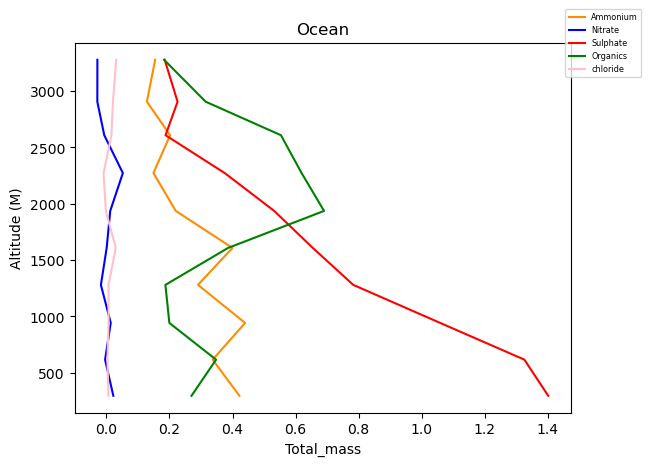

In [48]:
fig,ax = plt.subplots()
ax.plot(ocean_transport_plot['NH4_Ave_IsoK_STP_ZIEMBA'], ocean_transport_plot['GPS_Altitude_THORNHILL'], color = "darkorange", label = 'Ammonium')
ax.plot(ocean_transport_plot['NO3_Ave_IsoK_STP_ZIEMBA'], ocean_transport_plot['GPS_Altitude_THORNHILL'], color = "blue", label = 'Nitrate')
ax.plot(ocean_transport_plot['SO4_Ave_IsoK_STP_ZIEMBA'], ocean_transport_plot['GPS_Altitude_THORNHILL'], color = "red", label = 'Sulphate')
ax.plot(ocean_transport_plot['Org_Ave_IsoK_STP_ZIEMBA'], ocean_transport_plot['GPS_Altitude_THORNHILL'], color = "green", label = 'Organics')
ax.plot(ocean_transport_plot['Chl_Ave_IsoK_STP_ZIEMBA'], ocean_transport_plot['GPS_Altitude_THORNHILL'], color = "pink", label = 'chloride')

ax.set_ylabel('Altitude (M)')
ax.set_xlabel('Total_Mass')
ax.set_xlabel('Total_mass')
plt.title('Ocean')

ax.legend(bbox_to_anchor=(1.15, 1), loc = 'right', fontsize='xx-small')

In [49]:
# Concatenate the dataframes vertically (along rows)
North_America = pd.concat([DAY1000_subset_7, DAY1000_subset_7b, DAY1000_subset_17], axis=0)

# Reset the index of the merged dataframe
North_America.reset_index(drop=True, inplace=True)
North_America.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
count,67,67,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000
mean,2022-06-09 07:55:27.363589120,2022-06-09 07:55:28.363588864,32.231992,-65.009280,548.337133,1.534597,0.844009,0.070439,0.358500,0.012513,0.187758
min,2022-06-07 14:32:05.300000,2022-06-07 14:32:06.300000,32.170582,-65.065238,134.321500,0.242000,0.449000,-0.058000,-0.039000,-0.041304,-0.013000
25%,2022-06-07 14:35:12,2022-06-07 14:35:13,32.204178,-65.035459,340.337833,0.930000,0.589908,0.045000,0.153805,-0.006435,0.077000
50%,2022-06-07 19:08:21.500000,2022-06-07 19:08:22.500000,32.234441,-65.004622,544.358929,1.213000,0.892000,0.067000,0.369000,0.010211,0.141000
75%,2022-06-07 19:11:12,2022-06-07 19:11:13,32.255360,-64.980962,761.335779,2.277330,1.054000,0.094667,0.527428,0.026828,0.296000
max,2022-06-17 16:24:41.500000,2022-06-17 16:24:42.500000,32.302506,-64.968086,975.912308,2.362000,1.214000,0.184000,0.834000,0.076000,0.372000
std,NaN,NaN,0.036142,0.028948,245.678658,0.705220,0.238237,0.045368,0.245225,0.025023,0.118788


In [50]:
# Concatenate the dataframes vertically (along rows)
North_America2 = pd.concat([DAY7_subset_3000, DAY7b_subset_3000, DAY17_subset_3000], axis=0)

# Reset the index of the merged dataframe
North_America2.reset_index(drop=True, inplace=True)
North_America2.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
count,171,171,171.000000,171.000000,171.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000
mean,2022-06-09 13:56:08.766082304,2022-06-09 13:56:09.766081792,32.233562,-65.015713,2106.253110,0.814539,0.408619,0.020266,0.248293,0.006743,0.085741
min,2022-06-07 14:38:12,2022-06-07 14:38:13,32.162806,-65.062171,1003.411000,0.187310,0.098000,-0.093000,-0.270000,-0.047000,-0.049000
25%,2022-06-07 14:44:39.249999872,2022-06-07 14:44:40.249999872,32.210141,-65.045180,1545.078333,0.541600,0.185000,-0.020000,0.083000,-0.016500,0.041000
50%,2022-06-07 19:15:57.500000,2022-06-07 19:15:58.500000,32.236307,-65.016066,2079.076250,0.654000,0.267667,0.030000,0.248000,0.009000,0.079000
75%,2022-06-07 19:21:51.500000,2022-06-07 19:21:52.500000,32.253539,-64.988696,2612.969500,1.122000,0.365000,0.050000,0.390556,0.028000,0.123000
max,2022-06-17 16:38:08.500000,2022-06-17 16:38:09.500000,32.300554,-64.960247,3459.904000,1.648000,1.875333,0.118000,0.663000,0.065000,0.239000
std,NaN,NaN,0.034153,0.030088,664.456867,0.376949,0.394325,0.048648,0.214413,0.026872,0.056974


In [51]:
North_America_transport = pd.concat([North_America, North_America2], axis=0)
North_America_transport.reset_index(drop=True, inplace=True)
North_America_transport
nbins = 10
bins = np.linspace(North_America_transport.GPS_Altitude_THORNHILL.min(), North_America_transport.GPS_Altitude_THORNHILL.max(), nbins+1)
North_America_transport['Bins'] = pd.cut(North_America_transport['GPS_Altitude_THORNHILL'], bins)
North_America_transport_plot = North_America_transport.groupby('Bins').mean()
North_America_transport_plot

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
Bins,,,,,,,,,,,
"(134.322, 466.88]",2022-06-09 13:02:08.557795584,2022-06-09 13:02:09.557795584,32.235685,-64.999388,308.924614,1.454860,0.769728,0.062614,0.362441,0.013871,0.179920
"(466.88, 799.438]",2022-06-09 05:33:22.288461568,2022-06-09 05:33:23.288461568,32.233932,-65.012345,642.629880,1.523118,0.826184,0.073551,0.360182,0.007477,0.197537
"(799.438, 1131.996]",2022-06-09 01:15:49.249999872,2022-06-09 01:15:50.250000128,32.236622,-65.027877,960.000996,1.558318,1.121647,0.072777,0.363616,0.014466,0.172167
"(1131.996, 1464.554]",2022-06-09 11:28:39.232142848,2022-06-09 11:28:40.232142848,32.233448,-65.015428,1295.389357,1.103173,0.753377,0.037317,0.419379,0.020178,0.128450
"(1464.554, 1797.113]",2022-06-09 05:39:29.461538560,2022-06-09 05:39:30.461538560,32.240680,-65.024770,1634.387595,1.064379,0.529873,0.028562,0.217846,-0.002306,0.100067
"(1797.113, 2129.671]",2022-06-09 13:12:15.500000000,2022-06-09 13:12:16.500000000,32.223923,-64.997531,1967.386595,0.844279,0.231288,0.014523,0.098702,-0.007424,0.079047
"(2129.671, 2462.229]",2022-06-09 05:32:33.711538432,2022-06-09 05:32:34.711538432,32.222644,-65.021703,2299.311732,0.624266,0.283954,0.012594,0.243861,-0.002961,0.062591
"(2462.229, 2794.788]",2022-06-09 05:44:10.096153856,2022-06-09 05:44:11.096153856,32.238182,-65.036803,2626.167004,0.629626,0.234139,0.011718,0.219272,-0.002108,0.075177
"(2794.788, 3127.346]",2022-06-11 02:26:42.600000000,2022-06-11 02:26:43.600000000,32.217425,-65.007035,2960.931075,0.692485,0.212455,0.035042,0.240927,0.028509,0.076103


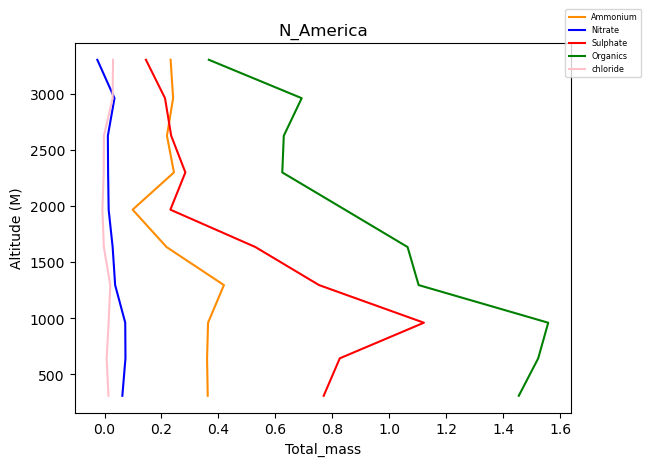

In [52]:
fig,ax = plt.subplots()
ax.plot(North_America_transport_plot['NH4_Ave_IsoK_STP_ZIEMBA'], North_America_transport_plot['GPS_Altitude_THORNHILL'], color = "darkorange", label = 'Ammonium')
ax.plot(North_America_transport_plot['NO3_Ave_IsoK_STP_ZIEMBA'], North_America_transport_plot['GPS_Altitude_THORNHILL'], color = "blue", label = 'Nitrate')
ax.plot(North_America_transport_plot['SO4_Ave_IsoK_STP_ZIEMBA'], North_America_transport_plot['GPS_Altitude_THORNHILL'], color = "red", label = 'Sulphate')
ax.plot(North_America_transport_plot['Org_Ave_IsoK_STP_ZIEMBA'], North_America_transport_plot['GPS_Altitude_THORNHILL'], color = "green", label = 'Organics')
ax.plot(North_America_transport_plot['Chl_Ave_IsoK_STP_ZIEMBA'], North_America_transport_plot['GPS_Altitude_THORNHILL'], color = "pink", label = 'chloride')

ax.set_ylabel('Altitude (M)')
ax.set_xlabel('Total_Mass')
ax.set_xlabel('Total_mass')
plt.title('N_America')

ax.legend(bbox_to_anchor=(1.15, 1), loc = 'right', fontsize='xx-small')

In [53]:
# Concatenate the dataframes vertically (along rows)
Caribbean = pd.concat([DAY1000_subset_3, DAY1000_subset_8, DAY1000_subset_10, DAY1000_subset_10b, DAY1000_subset_11, DAY1000_subset_11b], axis=0)

# Reset the index of the merged dataframe
Caribbean.reset_index(drop=True, inplace=True)
Caribbean.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
count,123,123,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000
mean,2022-06-09 21:31:55.508952320,2022-06-09 21:31:56.508952064,32.144896,-65.350799,537.555141,0.436948,1.117413,0.016934,0.283523,0.002528,0.037395
min,2022-06-03 13:45:28.789007104,2022-06-03 13:45:29.789007104,31.035566,-67.436618,121.109551,0.013037,0.575200,-0.058000,-0.183000,-0.039839,-0.065333
25%,2022-06-08 20:33:55.500000,2022-06-08 20:33:56.500000,31.372011,-65.838736,332.799583,0.279000,0.956000,-0.010125,0.198000,-0.008000,0.000000
50%,2022-06-10 19:58:13.842105088,2022-06-10 19:58:14.842105088,32.243637,-65.035595,538.712500,0.397000,1.123000,0.024000,0.308000,0.002000,0.028000
75%,2022-06-11 15:28:22.249999872,2022-06-11 15:28:23.249999872,32.297915,-64.986404,745.678750,0.501000,1.309077,0.033000,0.380024,0.012545,0.068500
max,2022-06-11 20:10:12.500000,2022-06-11 20:10:13.500000,34.214933,-64.424176,961.682500,1.078930,1.663827,0.100533,0.615250,0.043867,0.168000
std,NaN,NaN,0.834868,0.817590,242.594382,0.255300,0.247032,0.030510,0.164588,0.013993,0.049361


In [54]:
# Concatenate the dataframes vertically (along rows)
Caribbean2 = pd.concat([DAY3_subset_3000, DAY8_subset_3000, DAY10_subset_3000, DAY10b_subset_3000, DAY11_subset_3000, DAY11b_subset_3000, DAY13_subset_3000, DAY1000_subset_13b], axis=0)

# Reset the index of the merged dataframe
Caribbean2.reset_index(drop=True, inplace=True)
Caribbean2.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
count,431,431,431.000000,431.000000,431.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000
mean,2022-06-10 11:56:14.973697280,2022-06-10 11:56:15.973697792,32.145916,-65.235505,2137.176787,0.370113,0.498377,0.010834,0.166001,0.004496,0.035998
min,2022-06-03 13:53:27.769230848,2022-06-03 13:53:28.769230592,31.036776,-67.516110,121.140833,-0.081000,0.136714,-0.091000,-0.245000,-0.072841,-0.133000
25%,2022-06-08 20:43:57.750000128,2022-06-08 20:43:58.750000128,31.594612,-65.095014,1520.495568,0.171466,0.293000,-0.012000,0.041000,-0.009000,-0.006000
50%,2022-06-10 20:09:28.380952320,2022-06-10 20:09:29.380952320,32.237935,-65.027415,2152.079803,0.302000,0.412000,0.010500,0.161103,0.007000,0.022000
75%,2022-06-11 20:17:06.958333440,2022-06-11 20:17:07.958333440,32.279986,-64.979378,2784.418750,0.558000,0.597000,0.035000,0.299000,0.015922,0.083000
max,2022-06-13 19:50:47,2022-06-13 19:50:48,34.194709,-64.393900,3448.995000,1.288000,1.567000,0.115273,0.521000,0.064000,0.212000
std,NaN,NaN,0.684266,0.641941,769.502910,0.291403,0.304343,0.035830,0.158731,0.021531,0.061891


In [55]:
Caribbean_transport = pd.concat([Caribbean, Caribbean2], axis=0)
Caribbean_transport.reset_index(drop=True, inplace=True)
nbins = 10
bins = np.linspace(Caribbean_transport.GPS_Altitude_THORNHILL.min(), Caribbean_transport.GPS_Altitude_THORNHILL.max(), nbins+1)
Caribbean_transport['Bins'] = pd.cut(Caribbean_transport['GPS_Altitude_THORNHILL'], bins)
Caribbean_transport_plot = Caribbean_transport.groupby('Bins').mean()
Caribbean_transport_plot

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
Bins,,,,,,,,,,,
"(121.11, 453.898]",2022-06-10 08:15:30.052565760,2022-06-10 08:15:31.052565760,32.191856,-65.313912,291.786754,0.361189,1.104102,0.020872,0.195577,-0.001786,0.017894
"(453.898, 786.687]",2022-06-10 08:30:17.298771456,2022-06-10 08:30:18.298771712,32.160400,-65.325908,622.232260,0.382846,0.968346,0.000173,0.272561,0.005821,0.033927
"(786.687, 1119.475]",2022-06-10 09:04:27.546124032,2022-06-10 09:04:28.546124032,32.173842,-65.317143,946.773407,0.482860,1.015443,0.011897,0.343171,0.011685,0.045319
"(1119.475, 1452.264]",2022-06-10 10:28:56.329047808,2022-06-10 10:28:57.329047808,32.141455,-65.283488,1289.891052,0.493721,0.807317,0.000780,0.258439,0.002440,0.037633
"(1452.264, 1785.052]",2022-06-10 07:41:02.820278016,2022-06-10 07:41:03.820277760,32.190103,-65.301808,1622.972449,0.382386,0.646395,0.014635,0.232453,0.014752,0.050000
"(1785.052, 2117.841]",2022-06-10 09:25:12.416479232,2022-06-10 09:25:13.416479488,32.156321,-65.276586,1948.988665,0.365310,0.543136,0.019090,0.193064,-0.001310,0.038045
"(2117.841, 2450.629]",2022-06-10 10:03:42.093322496,2022-06-10 10:03:43.093322752,32.121154,-65.230782,2286.766603,0.434745,0.452066,0.023040,0.151619,0.011312,0.046196
"(2450.629, 2783.418]",2022-06-10 08:33:24.509021696,2022-06-10 08:33:25.509021696,32.093921,-65.206337,2622.173256,0.455541,0.338063,0.013137,0.117154,0.005598,0.049531
"(2783.418, 3116.206]",2022-06-10 09:21:11.269108992,2022-06-10 09:21:12.269108992,32.093062,-65.140272,2951.706673,0.312133,0.264505,0.012514,0.099216,0.002090,0.030535


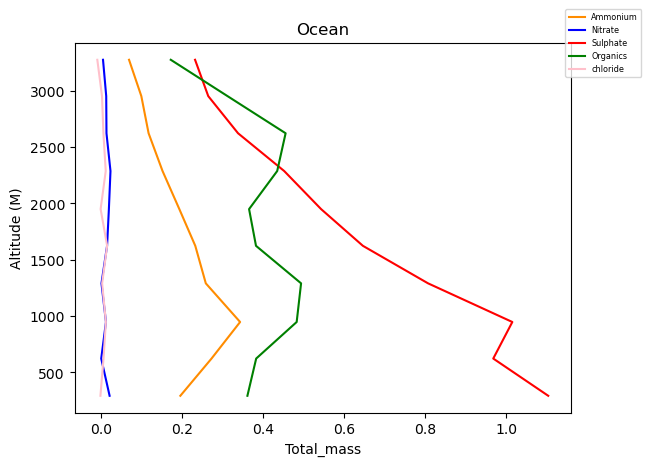

In [56]:
fig,ax = plt.subplots()
ax.plot(Caribbean_transport_plot['NH4_Ave_IsoK_STP_ZIEMBA'], Caribbean_transport_plot['GPS_Altitude_THORNHILL'], color = "darkorange", label = 'Ammonium')
ax.plot(Caribbean_transport_plot['NO3_Ave_IsoK_STP_ZIEMBA'], Caribbean_transport_plot['GPS_Altitude_THORNHILL'], color = "blue", label = 'Nitrate')
ax.plot(Caribbean_transport_plot['SO4_Ave_IsoK_STP_ZIEMBA'], Caribbean_transport_plot['GPS_Altitude_THORNHILL'], color = "red", label = 'Sulphate')
ax.plot(Caribbean_transport_plot['Org_Ave_IsoK_STP_ZIEMBA'], Caribbean_transport_plot['GPS_Altitude_THORNHILL'], color = "green", label = 'Organics')
ax.plot(Caribbean_transport_plot['Chl_Ave_IsoK_STP_ZIEMBA'], Caribbean_transport_plot['GPS_Altitude_THORNHILL'], color = "pink", label = 'chloride')

ax.set_ylabel('Altitude (M)')
ax.set_xlabel('Total_Mass')
ax.set_xlabel('Total_mass')
plt.title('Ocean')

ax.legend(bbox_to_anchor=(1.15, 1), loc = 'right', fontsize='xx-small')

In [57]:
Africa = pd.concat([DAY1000_subset_13, DAY1000_subset_13b, DAY1000_subset_14])
# Reset the index of the merged dataframe
Africa.reset_index(drop=True, inplace=True)
Africa.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
count,48,48,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000
mean,2022-06-13 21:57:17.503670528,2022-06-13 21:57:18.503670784,31.918298,-64.885146,541.348157,0.183120,0.674309,0.004811,0.124229,0.004939,-0.014565
min,2022-06-13 14:30:32.200000,2022-06-13 14:30:33.200000,30.635158,-65.097735,121.140833,-0.133000,0.380000,-0.061000,-0.142000,-0.047000,-0.093000
25%,2022-06-13 14:33:19.249999872,2022-06-13 14:33:20.249999872,32.200276,-65.034858,335.132500,0.070000,0.472000,-0.026000,0.023050,-0.010500,-0.041129
50%,2022-06-13 19:47:40.500000,2022-06-13 19:47:41.500000,32.235259,-64.988673,545.363575,0.173000,0.656714,-0.001000,0.136885,0.001000,-0.016042
75%,2022-06-13 19:50:19,2022-06-13 19:50:20,32.266888,-64.933701,747.631396,0.270062,0.845625,0.031712,0.235000,0.025000,0.012000
max,2022-06-14 16:07:10.500000,2022-06-14 16:07:11.500000,32.287260,-64.387230,954.156429,0.580000,0.984000,0.077000,0.325000,0.055000,0.061000
std,NaN,NaN,0.649748,0.245438,247.564084,0.153896,0.195065,0.039871,0.134914,0.024121,0.038495


In [58]:
Africa_transport = pd.concat([Africa, DAY14_subset_3000], axis=0)
Africa_transport.reset_index(drop=True, inplace=True)
nbins = 10
bins = np.linspace(Africa_transport.GPS_Altitude_THORNHILL.min(), Africa_transport.GPS_Altitude_THORNHILL.max(), nbins+1)
Africa_transport['Bins'] = pd.cut(Africa_transport['GPS_Altitude_THORNHILL'], bins)
Africa_transport_plot = Africa_transport.groupby('Bins').mean()
Africa_transport_plot

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
Bins,,,,,,,,,,,
"(121.141, 442.87]",2022-06-13 22:15:21.900000000,2022-06-13 22:15:22.900000000,31.899818,-64.858323,293.886773,0.167978,0.733928,0.015465,0.134535,0.005212,-0.028690
"(442.87, 764.599]",2022-06-13 22:16:42.277777920,2022-06-13 22:16:43.277777920,31.907996,-64.900447,613.039744,0.203859,0.606709,-0.002311,0.055524,0.006731,-0.000183
"(764.599, 1086.328]",2022-06-13 22:42:49.416666880,2022-06-13 22:42:50.416666624,31.829494,-64.852175,884.663618,0.212229,0.666793,-0.009561,0.213382,0.002607,-0.009662
"(1086.328, 1408.057]",2022-06-14 16:07:48.666666752,2022-06-14 16:07:49.666666496,30.641470,-64.404228,1246.981444,0.557133,0.368867,-0.002000,0.062867,0.014933,0.047533
"(1408.057, 1729.786]",2022-06-14 16:08:22.249999872,2022-06-14 16:08:23.249999872,30.656191,-64.432512,1539.005417,0.376500,0.282000,-0.008500,-0.067750,-0.003500,0.019500
"(1729.786, 2051.515]",2022-06-14 16:09:00.750000128,2022-06-14 16:09:01.750000128,30.688544,-64.415486,1873.197944,0.386800,0.180000,-0.004525,0.016950,0.010225,0.002900
"(2051.515, 2373.244]",2022-06-14 16:09:38.875000064,2022-06-14 16:09:39.875000064,30.677510,-64.375355,2207.540278,0.029000,0.099667,-0.029000,-0.032667,0.029000,-0.015000
"(2373.244, 2694.973]",2022-06-14 16:10:18.249999872,2022-06-14 16:10:19.249999872,30.643522,-64.384657,2541.211023,0.045100,0.150100,0.063500,-0.173050,0.007300,-0.022750
"(2694.973, 3016.702]",2022-06-14 16:10:59.500000000,2022-06-14 16:11:00.500000000,30.655523,-64.424406,2877.968333,0.273125,0.167625,0.047438,0.255812,0.039000,-0.021625


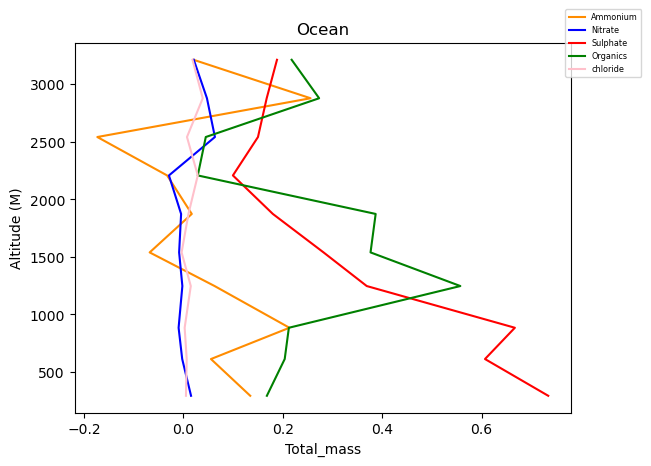

In [59]:
fig,ax = plt.subplots()
ax.plot(Africa_transport_plot['NH4_Ave_IsoK_STP_ZIEMBA'], Africa_transport_plot['GPS_Altitude_THORNHILL'], color = "darkorange", label = 'Ammonium')
ax.plot(Africa_transport_plot['NO3_Ave_IsoK_STP_ZIEMBA'], Africa_transport_plot['GPS_Altitude_THORNHILL'], color = "blue", label = 'Nitrate')
ax.plot(Africa_transport_plot['SO4_Ave_IsoK_STP_ZIEMBA'], Africa_transport_plot['GPS_Altitude_THORNHILL'], color = "red", label = 'Sulphate')
ax.plot(Africa_transport_plot['Org_Ave_IsoK_STP_ZIEMBA'], Africa_transport_plot['GPS_Altitude_THORNHILL'], color = "green", label = 'Organics')
ax.plot(Africa_transport_plot['Chl_Ave_IsoK_STP_ZIEMBA'], Africa_transport_plot['GPS_Altitude_THORNHILL'], color = "pink", label = 'chloride')

ax.set_ylabel('Altitude (M)')
ax.set_xlabel('Total_Mass')
ax.set_xlabel('Total_mass')
plt.title('Ocean')

ax.legend(bbox_to_anchor=(1.15, 1), loc = 'right', fontsize='xx-small')

In [60]:
# Concatenate the dataframes vertically (along rows)
merged_df = pd.concat([Caribbean.describe(), Caribbean2.describe(), North_America.describe(), North_America2.describe(), ocean.describe(), ocean2.describe(), Africa.describe(), DAY14_subset_3000.describe()], axis=0)

# Reset the index of the merged dataframe
merged_df.reset_index(drop=False, inplace=True)

# Display the merged dataframe
merged_df
merged_df.to_csv('C:/Users/taiwoajayi/OneDrive - University of Arizona/python/chemistry_mass_description.csv')